In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import *

# Model
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import average_precision_score, log_loss, accuracy_score, classification_report
from bayes_opt import BayesianOptimization
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
from P7_01_functions import *
import P7_01_functions
help(P7_01_functions)

Help on module P7_01_functions:

NAME
    P7_01_functions - Fichier contenant les fonctions du P7

FUNCTIONS
    cat_analyzer(dataframe, variable, target=None)
        Categorical Variables & Target
    
    corr_plot(data, remove=['Id'], corr_coef='pearson', figsize=(20, 20))
        Numerical Variables
    
    display_importances(feature_importance_df_)
    
    display_precision_recall(y_, oof_preds_, folds_idx_)
    
    display_roc_curve(y_, oof_preds_, folds_idx_)
    
    grab_col_names(dataframe, cat_th=10, car_th=20, show_date=False)
        Grab Column Names
    
    high_correlation(data, remove=['SK_ID_CURR', 'SK_ID_BUREAU'], corr_coef='pearson', corr_value=0.7)
        Get high correlated variables
    
    missing_values(data, plot=False)
        Missing Value
    
    num_plot(data, num_cols, remove=['Id'], hist_bins=10, figsize=(20, 4))
        Plot numerical variables
    
    one_hot_encoder(df, nan_as_category=True)
        One-hot encoding for categorical columns w

**Note :**

Pour mon sommaire, j'utilise l'extension Table of Contents de Jupyter : 
https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html
    
Toute la partie exploration de données vient de Kaggle : https://www.kaggle.com/ekrembayar/homecredit-default-risk-step-by-step-1st-notebook

In [5]:
col_description = pd.read_csv("home-credit-default-risk/HomeCredit_columns_description.csv")
col_description.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [6]:
col_description[col_description['Row'] == 'TARGET']['Description']

1    Target variable (1 - client with payment diffi...
Name: Description, dtype: object

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
___
Variable cible (1 - client ayant des difficultés de paiement : il/elle a eu un retard de paiement de plus de X jours sur au moins une des Y premières échéances du prêt dans notre échantillon, 0 - tous les autres cas)

# 1. Investigate intersections to key ids of tables!

Import tables and investigate these items:

- Show dimension of tables to see differences
- Is there an unbalanced problem in the target variable?
- How many rows are intersected between two tables?

In [80]:
train = pd.read_csv("home-credit-default-risk/application_train.csv")
test = pd.read_csv("home-credit-default-risk/application_test.csv")
bureau = pd.read_csv("home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("home-credit-default-risk/bureau_balance.csv")
pos = pd.read_csv('home-credit-default-risk/POS_CASH_balance.csv')
cc = pd.read_csv('home-credit-default-risk/credit_card_balance.csv')
ins = pd.read_csv('home-credit-default-risk/installments_payments.csv')
prev = pd.read_csv('home-credit-default-risk/previous_application.csv')

In [83]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [84]:
print("Dimensions")

dict_df = {'application_train shape :': train.shape, 
           'application_test shape :' : test.shape, 
           'bureau shape :' : bureau.shape,
           'bureau_balance shape :' : bureau_balance.shape,
           'POS_CASH_balance shape :' : pos.shape, 
           'credit_card_balance shape :' : cc.shape, 
           'installments_payments shape :' : ins.shape, 
           'previous_application shape:' : prev.shape}

for key, value in dict_df.items():
    print(f'{key :-<30} {value}')

Dimensions
application_train shape :----- (307511, 122)
application_test shape :------ (48744, 121)
bureau shape :---------------- (1716428, 17)
bureau_balance shape :-------- (27299925, 3)
POS_CASH_balance shape :------ (10001358, 8)
credit_card_balance shape :--- (3840312, 23)
installments_payments shape :- (13605401, 8)
previous_application shape:--- (1670214, 37)


In [89]:
print("Missing values")

dict_df = {'application_train :': train, 
           'application_test :' : test, 
           'bureau :' : bureau,
           'bureau_balance :' : bureau_balance,
           'POS_CASH_balance :' : pos, 
           'credit_card_balance :' : cc, 
           'installments_payments :' : ins, 
           'previous_application :' : prev}

for key, value in dict_df.items():
    val_manq = value.isna().sum().sum()/(value.shape[0] * value.shape[1]) *100
    print(f'{key :-<30} {val_manq}')

Missing values
application_train :----------- 24.39594190712943
application_test :------------ 23.811686761532336
bureau :---------------------- 13.502552290879322
bureau_balance :-------------- 0.0
POS_CASH_balance :------------ 0.06518864738168557
credit_card_balance :--------- 6.654074392687479
installments_payments :------- 0.005337953655316738
previous_application :-------- 17.97687747344498


**Balanced or Unbalanced?**

If we observe TARGET variable like below, we can see there is an unbalanced problem here. 

- Train data has 307511 rows.
- The 1 class in target has 24825 rows and its ratio is %8 in whole data
- The 0 class in target has 282 686 rows and its ratio is %92 in whole data
- This result shows us there is an unbalanced problem in target

In [15]:
# Imbalanced
cat_analyzer(train, "TARGET")

TARGET
    COUNT  RATIO
0  282686   0.92
1   24825   0.08




**Intersections**

Tables are connected each other with **SK_ID_CURR**, **SK_ID_BUREAU** and **SK_ID_PREV** key ids. I won't show all intersections below, but you will see the point.

In [91]:
# Train Test
print("Number of unique observations in the SK_ID_CURR variable \n TRAIN: {} \t TEST: {} \n".format(train.SK_ID_CURR.nunique(), test.SK_ID_CURR.nunique()))

# Bureau & Bureau Balance
print("Number of unique observations in the SK_ID_BUREAU variable \n BUREAU: {} \t BUREAU BALANCE: {} \t INTERSECTION: {} \n".format(bureau.SK_ID_BUREAU.nunique(), bureau_balance.SK_ID_BUREAU.nunique(), bureau[bureau.SK_ID_BUREAU.isin(bureau_balance.SK_ID_BUREAU.unique())].SK_ID_BUREAU.nunique()))

# Train-Test & Bureau
print("Number of unique observations in the SK_ID_CURR variable \n TRAIN & BUREAU INTERSECTION: {} \t TEST & BUREAU INTERSECTION: {} \n".format(train[train.SK_ID_CURR.isin(bureau.SK_ID_CURR.unique())].SK_ID_CURR.nunique(),test[test.SK_ID_CURR.isin(bureau.SK_ID_CURR.unique())].SK_ID_CURR.nunique()))

del train, test, bureau, bureau_balance, pos, cc, ins, prev

Number of unique observations in the SK_ID_CURR variable 
 TRAIN: 307511 	 TEST: 48744 

Number of unique observations in the SK_ID_BUREAU variable 
 BUREAU: 1716428 	 BUREAU BALANCE: 817395 	 INTERSECTION: 774354 

Number of unique observations in the SK_ID_CURR variable 
 TRAIN & BUREAU INTERSECTION: 263491 	 TEST & BUREAU INTERSECTION: 42320 



# 2. Bureau Balance

**Description**
1. Monthly balances of previous credits in Credit Bureau.
2. This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

STATUS: "Status of Credit Bureau loan during the month (active, closed, DPD0-30,…
- C means closed,
- X means status unknown,
- 0 means no DPD,
- 1 means maximal did during month between 1-30,
- 2 means DPD 31-60,
- … 5 means DPD 120+ or sold or written off)",

> **NOTE:** If we work on programming or data science and so on, we should pay attention about memory usage for efficiency. There are many tables in this problem and memory usage of some tables might be so much. We can decrease memory usage each table for efficency by using reduce_mem_usage function. For this reason, we will use reduce_mem_usage function in every step. 

In [94]:
bureau_balance = pd.read_csv("home-credit-default-risk/bureau_balance.csv")
bureau_balance = reduce_mem_usage(bureau_balance)

print(bureau_balance.shape, "\n")

bureau_balance.head()

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
(27299925, 3) 



,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## EDA for Bureau Balance

In [95]:
# missing values
bureau_balance.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [96]:
# Descriptive Statistics
print(bureau_balance.MONTHS_BALANCE.agg({"min", "max", "mean", "median", "std"}))

print(96/12, " Max year")

median   -25.00
min      -96.00
max        0.00
std       23.86
mean     -30.74
Name: MONTHS_BALANCE, dtype: float64
8.0  Max year


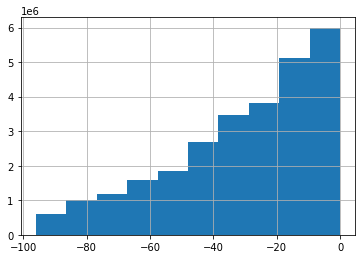

(<AxesSubplot:>, None)

In [97]:
# Histogram
bureau_balance.MONTHS_BALANCE.hist(), plt.show()

In [98]:
bureau_balance.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

## Data Manipulation & Feature Engineering for Bureau Balance

In [99]:
# One-Hot Encoder
bb, bb_cat = one_hot_encoder(bureau_balance, nan_as_category=False)
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,0,1,0


In [100]:
# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

In [101]:
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_aggregations

{'MONTHS_BALANCE': ['min', 'max', 'size'],
 'STATUS_0': ['mean'],
 'STATUS_1': ['mean'],
 'STATUS_2': ['mean'],
 'STATUS_3': ['mean'],
 'STATUS_4': ['mean'],
 'STATUS_5': ['mean'],
 'STATUS_C': ['mean'],
 'STATUS_X': ['mean']}

In [102]:
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.shape

(817395, 11)

In [103]:
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bb_agg.columns

Index(['MONTHS_BALANCE_MIN', 'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE',
       'STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN',
       'STATUS_4_MEAN', 'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN'],
      dtype='object')

In [104]:
# Status Sum
bb_agg["STATUS_C0_MEAN_SUM"] = bb_agg[["STATUS_C_MEAN",
                                       "STATUS_0_MEAN"]].sum(axis = 1)

bb_agg["STATUS_12_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN",
                                       "STATUS_2_MEAN"]].sum(axis = 1)

bb_agg["STATUS_345_MEAN_SUM"] = bb_agg[["STATUS_3_MEAN",
                                        "STATUS_4_MEAN",
                                        "STATUS_5_MEAN"]].sum(axis = 1)

bb_agg["STATUS_12345_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN",
                                          "STATUS_2_MEAN",
                                          "STATUS_3_MEAN",
                                          "STATUS_4_MEAN",
                                          "STATUS_5_MEAN"]].sum(axis = 1)

In [105]:
# Find the first month when the credit is closed!
closed = bureau_balance[bureau_balance.STATUS == "C"]
closed = closed.groupby("SK_ID_BUREAU").MONTHS_BALANCE.min().reset_index().rename({"MONTHS_BALANCE":"MONTHS_BALANCE_FIRST_C"}, axis = 1)
closed.shape

(449604, 2)

In [106]:
# One-Hot Encoder
bb, bb_cat = one_hot_encoder(bureau_balance, nan_as_category=False)

# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

for col in bb_cat:
    bb_aggregations[col] = ['mean']

bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

# Status Sum
bb_agg["STATUS_C0_MEAN_SUM"] = bb_agg[["STATUS_C_MEAN",
                                       "STATUS_0_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN",
                                       "STATUS_2_MEAN"]].sum(axis = 1)
bb_agg["STATUS_345_MEAN_SUM"] = bb_agg[["STATUS_3_MEAN",
                                        "STATUS_4_MEAN",
                                        "STATUS_5_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12345_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN",
                                          "STATUS_2_MEAN",
                                          "STATUS_3_MEAN",
                                          "STATUS_4_MEAN",
                                          "STATUS_5_MEAN"]].sum(axis = 1)

# Find the first month when the credit is closed!
closed = bureau_balance[bureau_balance.STATUS == "C"]
closed = closed.groupby("SK_ID_BUREAU").MONTHS_BALANCE.min().reset_index().rename({"MONTHS_BALANCE":"MONTHS_BALANCE_FIRST_C"}, axis = 1)
closed["MONTHS_BALANCE_FIRST_C"] = np.abs(closed["MONTHS_BALANCE_FIRST_C"])
bb_agg = pd.merge(bb_agg, closed, how = "left", on = "SK_ID_BUREAU")
bb_agg["MONTHS_BALANCE_CLOSED_DIF"] = np.abs(bb_agg.MONTHS_BALANCE_MIN) - bb_agg.MONTHS_BALANCE_FIRST_C

del closed, bb_aggregations, bureau_balance, bb_cat

In [107]:
print("BURAU BALANCE SHAPE:", bb_agg.shape, "\n")

bb_agg.head()

BURAU BALANCE SHAPE: (817395, 18) 



,SK_ID_BUREAU,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_C0_MEAN_SUM,STATUS_12_MEAN_SUM,STATUS_345_MEAN_SUM,STATUS_12345_MEAN_SUM,MONTHS_BALANCE_FIRST_C,MONTHS_BALANCE_CLOSED_DIF
0,5001709,-96,0,97,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.11,0.89,0.00,0.00,0.00,85.00,11.00
1,5001710,-82,0,83,0.06,0.00,0.00,0.00,0.00,0.00,0.58,0.36,0.64,0.00,0.00,0.00,47.00,35.00
2,5001711,-3,0,4,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.75,0.00,0.00,0.00,NaN,NaN
3,5001712,-18,0,19,0.53,0.00,0.00,0.00,0.00,0.00,0.47,0.00,1.00,0.00,0.00,0.00,8.00,10.00
4,5001713,-21,0,22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,NaN,NaN


# 3. Bureau

1. All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
2. For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [92]:
bureau = pd.read_csv("home-credit-default-risk/bureau.csv")
bureau = reduce_mem_usage(bureau)

print(bureau.shape, "\n")

bureau.head()

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
(1716428, 17) 



,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,"91,323.00",0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,"1,075.00",NaN,NaN,0,"225,000.00","171,342.00",NaN,0.00,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,"464,323.50",NaN,NaN,0.00,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,"90,000.00",NaN,NaN,0.00,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,"1,197.00",NaN,"77,674.50",0,"2,700,000.00",NaN,NaN,0.00,Consumer credit,-21,NaN


## Merge Bureau Balance and Bureau

In [108]:
# LEFT JOIN WITH BUREAU
bureau = pd.merge(bureau, bb_agg, how='left', on='SK_ID_BUREAU')
del bb_agg

print(bureau.shape, "\n")

(1716428, 34) 



## EDA for Bureau

Missing values are one of the biggest problems in data analytics. There are many things to do them but this project we won't focus on missing values.

In [37]:
# Are there any missing values in the data?
missing_values(bureau, plot = False)

Number of Variables include Missing Values: 24 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0   MONTHS_BALANCE_CLOSED_DIF      1299036           0.76   float64
1      MONTHS_BALANCE_FIRST_C      1299036           0.76   float64
2                 AMT_ANNUITY      1226791           0.71   float32
3      AMT_CREDIT_MAX_OVERDUE      1124488           0.66   float32
4               STATUS_5_MEAN       942074           0.55   float64
5               STATUS_0_MEAN       942074           0.55   float64
6               STATUS_1_MEAN       942074           0.55   float64
7               STATUS_2_MEAN       942074           0.55   float64
8               STATUS_3_MEAN       942074           0.55   float64
9               STATUS_4_MEAN       942074           0.55   float64
10              STATUS_C_MEAN       942074           0.55   float64
11         MONTHS_BALANCE_MAX       942074           0.55   float64
12              STATUS_X_MEAN       942074           0.55   float64

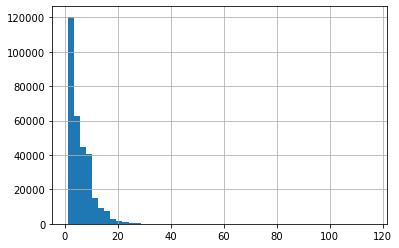

max      116.00
min        1.00
mean       5.61
median     4.00
std        4.43
Name: SK_ID_BUREAU, dtype: float64

In [38]:
# How many loans of each customer are there to from Credit Bureau?

bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().hist(bins=50), plt.show()
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().agg({"min", "max", "mean", "median", "std"})

**grab_col_names** is very useful function to understand the data for first step. It prints and keeps information about how many there are datetime, categorical, numerical variables. Also variables may be of a different type than they are. For example, one column might be numerical but actually it behaves like a categorical variable. So, grab_col_names function gives us a chance to understand the data deeply.

In [39]:
# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(bureau, car_th=10)

print("")

# Categorical Features
print(cat_cols, cat_but_car)

Observations: 1716428
Variables: 34
date_cols: 0
cat_cols: 2
num_cols: 23
cat_but_car: 1
num_but_cat: 0

['CREDIT_ACTIVE', 'CREDIT_CURRENCY'] ['CREDIT_TYPE']


**cat_analyzer** function gives us value counts and ratio of categories in a column. We can learn which categories or columns might be more important than others to use on a model. Also cat_analyzer tells us which columns include rare category. If there is any rare categories in a column, we can use **Rare Encoder** function to combine different rare categories. The main purpose of Rare Encoder is to reduce number of category in a column so the column might be more useful for modelling.

In [40]:
# Cat Analyzer
for i in cat_cols + cat_but_car:
    cat_analyzer(bureau, i)

CREDIT_ACTIVE
            COUNT  RATIO
Closed    1079273   0.63
Active     630607   0.37
Sold         6527   0.00
Bad debt       21   0.00


CREDIT_CURRENCY
              COUNT  RATIO
currency 1  1715020   1.00
currency 2     1224   0.00
currency 3      174   0.00
currency 4       10   0.00


CREDIT_TYPE
                                                COUNT  RATIO
Consumer credit                               1251615   0.73
Credit card                                    402195   0.23
Car loan                                        27690   0.02
Mortgage                                        18391   0.01
Microloan                                       12413   0.01
Loan for business development                    1975   0.00
Another type of loan                             1017   0.00
Unknown type of loan                              555   0.00
Loan for working capital replenishment            469   0.00
Cash loan (non-earmarked)                          56   0.00
Real estate loan       

After results of cat_analyzer: 
- I think that CREDIT_CURRENCY variable is useless for modelling. Almost all of rows are currency 1 category.
- CREDIT_ACTIVE variable might be useful. There are two rare categories in this column. We can combine these two categories so we assign a new category as Sold_BadDebt. Briefly, CREDIT_ACTIVE variable includes 3 categories as Active, Closed and Sold_BadDebt.
- CREDIT_TYPE might be useful but there are some rare categories too. We should reduce number of category. 

In [41]:
# Numeric Features
bureau.drop(["SK_ID_CURR" ,"SK_ID_BUREAU"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]


,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_C0_MEAN_SUM,STATUS_12_MEAN_SUM,STATUS_345_MEAN_SUM,STATUS_12345_MEAN_SUM,MONTHS_BALANCE_FIRST_C,MONTHS_BALANCE_CLOSED_DIF
mean,"-1,142.11",0.82,NaN,NaN,"3,825.36",0.01,"354,577.31","137,081.83","6,229.78",37.91,-593.75,"15,713.27",-36.29,-6.06,31.23,0.41,0.01,0.00,0.00,0.00,0.00,0.36,0.22,0.77,0.01,0.00,0.01,31.74,11.76
std,795.16,36.54,NaN,NaN,"205,987.31",0.10,"1,150,276.62","679,074.88","44,896.66","5,937.52",720.75,"325,655.59",25.45,15.06,23.48,0.35,0.05,0.01,0.00,0.00,0.03,0.37,0.34,0.34,0.05,0.03,0.06,22.91,10.78
min,"-2,922.00",0.00,"-42,048.00","-42,016.00",0.00,0.00,0.00,"-4,705,600.50","-586,406.12",0.00,"-41,947.00",0.00,-96.00,-95.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1%,"-2,867.00",0.00,"-2,572.00","-2,640.00",0.00,0.00,0.00,0.00,0.00,0.00,"-2,531.00",0.00,-93.00,-72.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10%,"-2,443.00",0.00,"-1,922.00","-2,160.00",0.00,0.00,"22,500.00",0.00,0.00,0.00,"-1,561.00",0.00,-78.00,-25.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,3.00
25%,"-1,666.00",0.00,"-1,138.00","-1,489.00",0.00,0.00,"51,300.00",0.00,0.00,0.00,-908.00,0.00,-53.00,0.00,12.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.67,0.00,0.00,0.00,13.00,5.00
50%,-987.00,0.00,-330.00,-897.00,0.00,0.00,"125,518.50",0.00,0.00,0.00,-395.00,0.00,-31.00,0.00,25.00,0.33,0.00,0.00,0.00,0.00,0.00,0.24,0.03,0.95,0.00,0.00,0.00,28.00,9.00
75%,-474.00,0.00,474.00,-425.00,0.00,0.00,"315,000.00","40,153.50",0.00,0.00,-33.00,"13,500.00",-15.00,0.00,45.00,0.73,0.00,0.00,0.00,0.00,0.00,0.74,0.31,1.00,0.00,0.00,0.00,46.00,13.00
80%,-385.00,0.00,725.00,-340.00,45.00,0.00,"423,000.00","90,009.00",0.00,0.00,-25.00,"17,660.21",-12.00,0.00,50.00,0.83,0.00,0.00,0.00,0.00,0.00,0.80,0.44,1.00,0.00,0.00,0.00,52.00,17.00
90%,-215.00,0.00,"1,334.00",-178.00,"7,594.88",0.00,"778,754.75","295,456.50",0.00,0.00,-13.00,"31,432.50",-7.00,0.00,67.00,0.97,0.02,0.00,0.00,0.00,0.00,0.88,1.00,1.00,0.03,0.00,0.03,68.00,24.00


Summary stats give us many insights about numerical variables. Also percentiles, minimum and maximum values show us that there are any outliers or not. For example, In AMT_CREDIT_MAX_OVERDUE variable maximum value is 115,987,184.00 but 99 percentile is 41,988.75. This difference is too much between max and 99% values. If you want an accurate model more, outliers are one of the problems you should focus on.

If you want to understand numerical variables better, you should plot them and look their distributions.

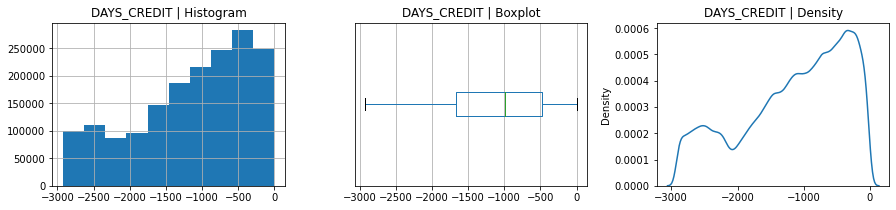

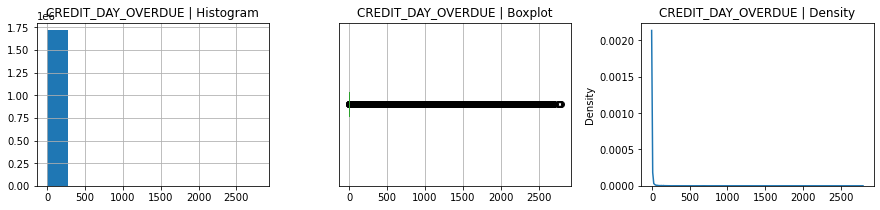

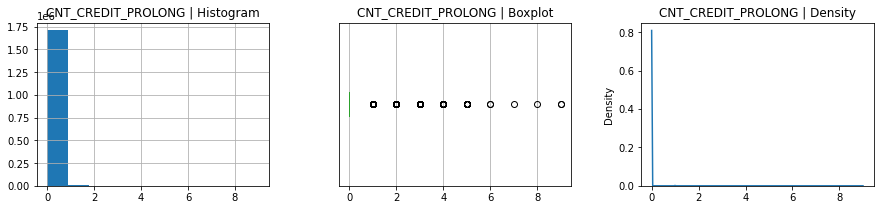

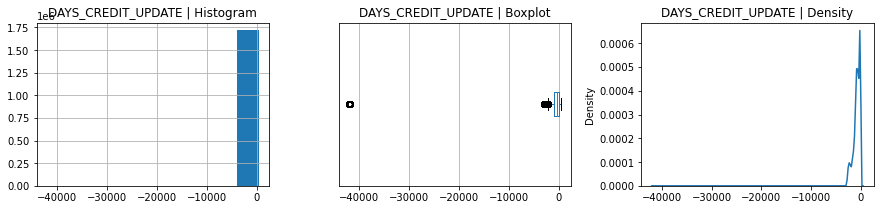

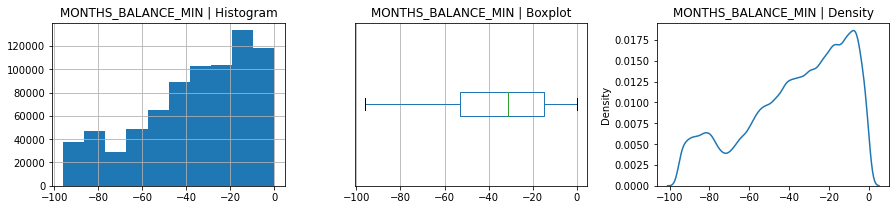

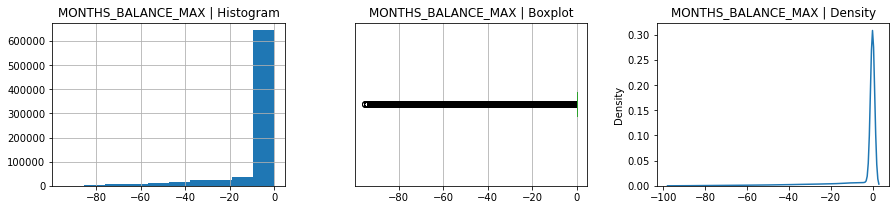

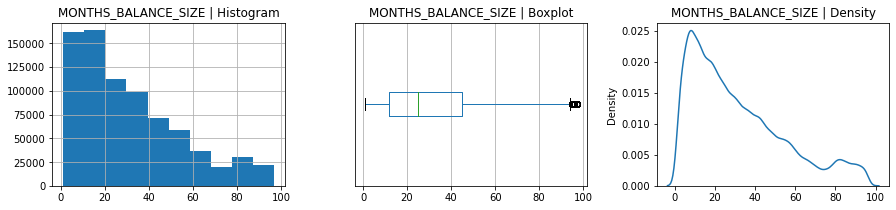

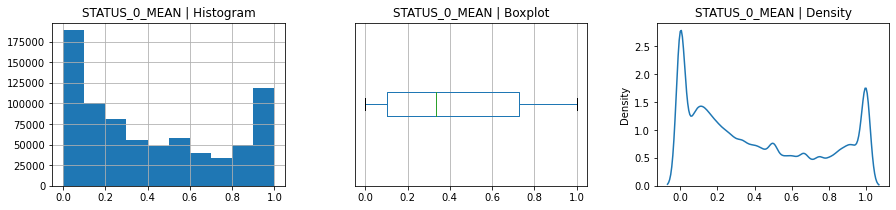

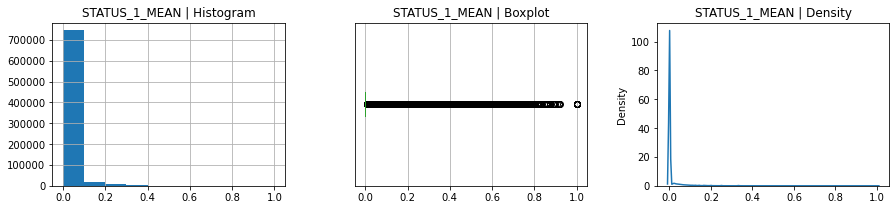

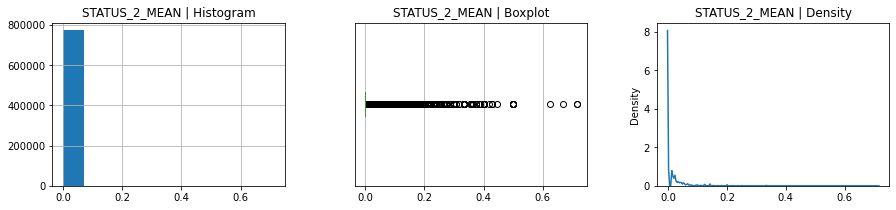

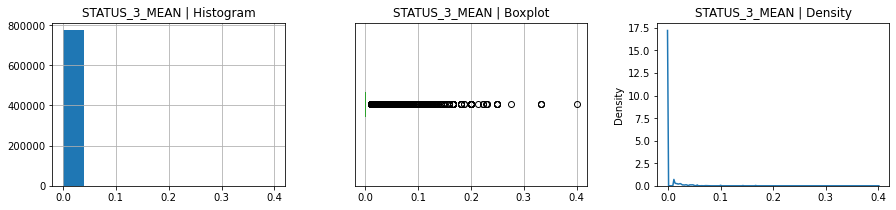

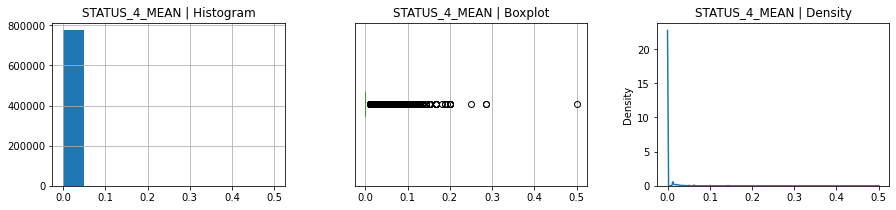

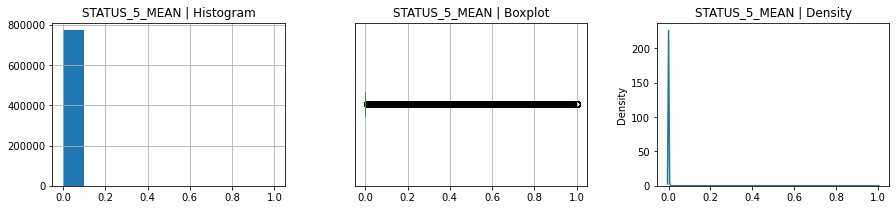

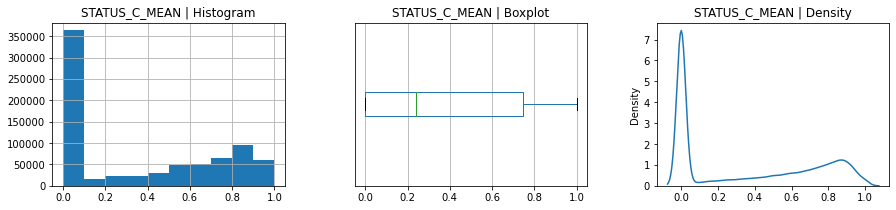

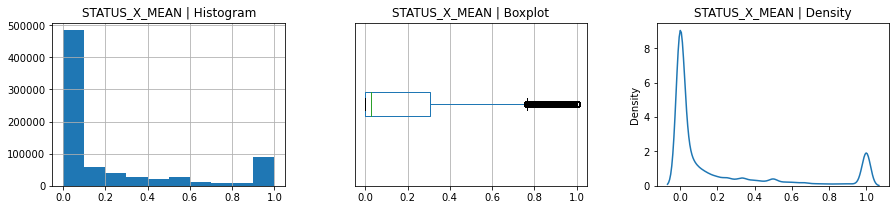

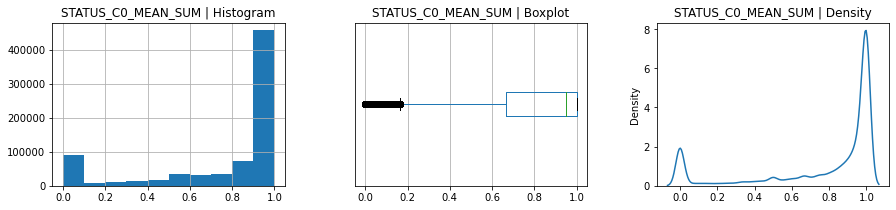

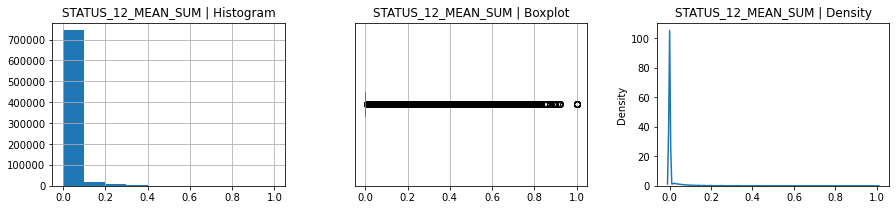

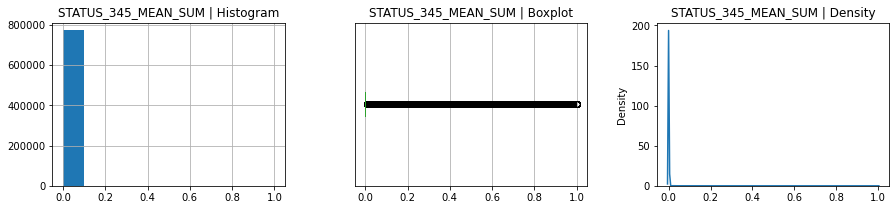

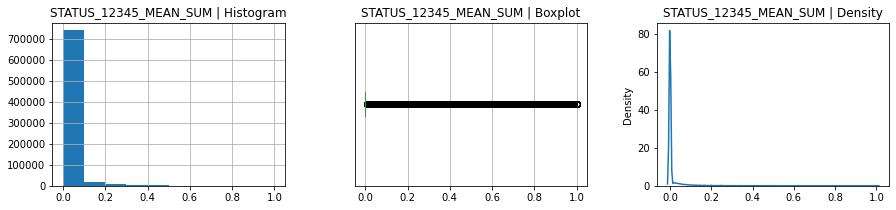

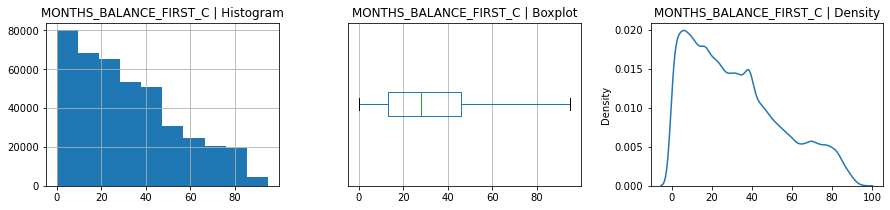

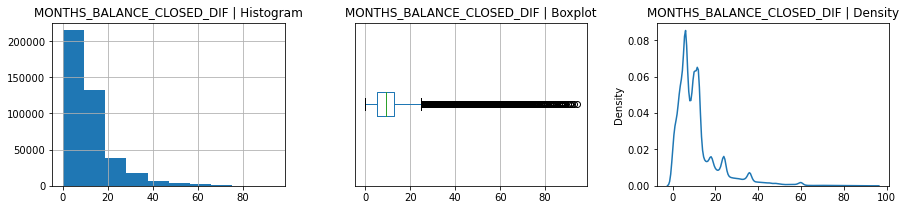

In [42]:
# Quick Visualization for numerical variables
num_plot(bureau, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_BUREAU'], figsize = (15,3))

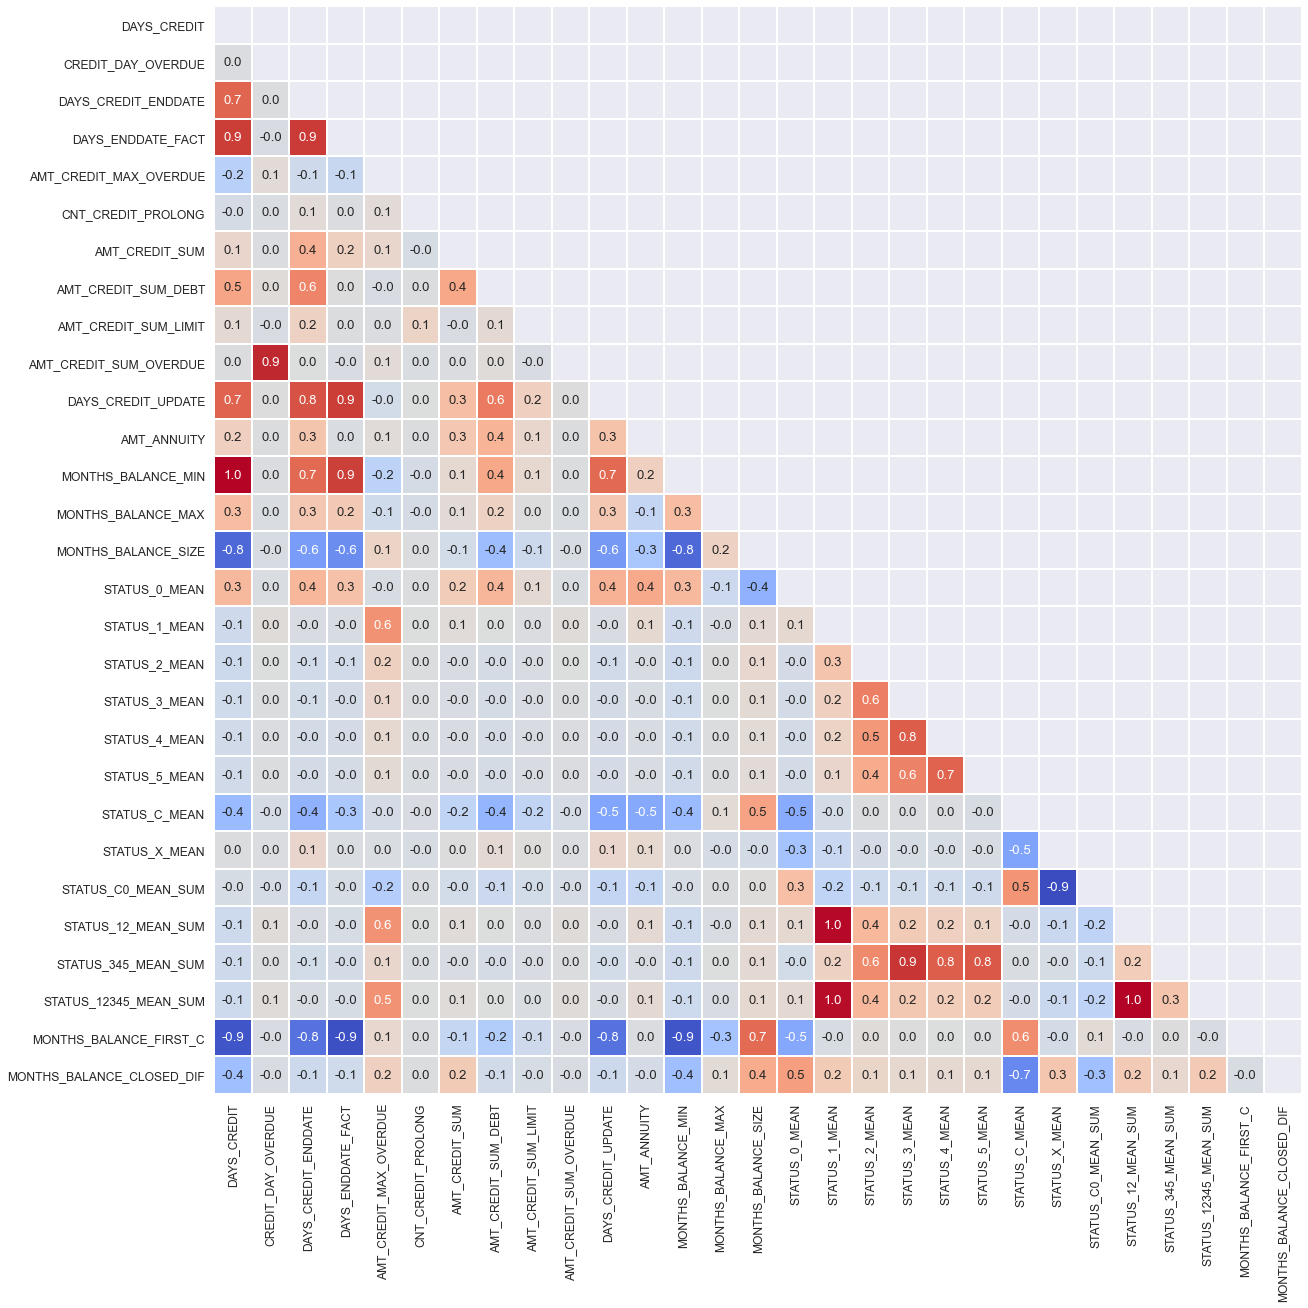

In [43]:
# Correlation
corr_plot(bureau, remove=['SK_ID_CURR','SK_ID_BUREAU'], corr_coef = "spearman")

In [44]:
high_correlation(bureau, remove=['SK_ID_CURR','SK_ID_BUREAU'], corr_coef = "spearman", corr_value = 0.7)

DAYS_CREDIT
-------------------------------
MONTHS_BALANCE_MIN        1.00
DAYS_ENDDATE_FACT         0.87
DAYS_CREDIT_UPDATE        0.74
DAYS_CREDIT_ENDDATE       0.74
MONTHS_BALANCE_SIZE      -0.82
MONTHS_BALANCE_FIRST_C   -0.90
Name: DAYS_CREDIT, dtype: float64


CREDIT_DAY_OVERDUE
-------------------------------
AMT_CREDIT_SUM_OVERDUE   0.93
Name: CREDIT_DAY_OVERDUE, dtype: float64


DAYS_CREDIT_ENDDATE
-------------------------------
DAYS_ENDDATE_FACT         0.88
DAYS_CREDIT_UPDATE        0.81
DAYS_CREDIT               0.74
MONTHS_BALANCE_MIN        0.72
MONTHS_BALANCE_FIRST_C   -0.77
Name: DAYS_CREDIT_ENDDATE, dtype: float64


DAYS_ENDDATE_FACT
-------------------------------
DAYS_CREDIT_ENDDATE       0.88
DAYS_CREDIT               0.87
DAYS_CREDIT_UPDATE        0.87
MONTHS_BALANCE_MIN        0.87
MONTHS_BALANCE_FIRST_C   -0.92
Name: DAYS_ENDDATE_FACT, dtype: float64


AMT_CREDIT_SUM_OVERDUE
-------------------------------
CREDIT_DAY_OVERDUE   0.93
Name: AMT_CREDIT_SUM_OVERDUE, d

## Data Manipulation & Feature Engineering for Bureau

In [45]:
# FEATURE ENGINEERING FOR BUREAU

# Categorical Variables
# -----------------------------------------------------------
# Useless
bureau.drop("CREDIT_CURRENCY", axis = 1, inplace = True)

# Rare Categories
bureau["CREDIT_ACTIVE"] = np.where(bureau.CREDIT_ACTIVE.isin(["Sold", "Bad debt"]), "Sold_BadDebt",
                                   bureau.CREDIT_ACTIVE)

bureau["CREDIT_TYPE"] = np.where(
    ~bureau.CREDIT_TYPE.isin(
        ["Consumer credit", "Credit card", "Car loan", "Mortgage", "Microloan"]
    ), "Other", bureau["CREDIT_TYPE"])

# One-Hot Encoder
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=False)


# Numerical Variables
# -----------------------------------------------------------

# Bureau and bureau_balance numeric features
cal = ['min', 'max', 'mean', 'sum', 'median','std']
cols1 = [
    'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_CREDIT_UPDATE','CREDIT_DAY_OVERDUE',
    'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE',
    'AMT_CREDIT_SUM_LIMIT', 'AMT_ANNUITY', 'CNT_CREDIT_PROLONG', 'MONTHS_BALANCE_MIN',
    'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE', 'MONTHS_BALANCE_FIRST_C', 'MONTHS_BALANCE_CLOSED_DIF'
]

num_aggregations = {}


for i in cols1:
    num_aggregations[i] = cal
    
    
# Bureau and bureau_balance categorical features
cat_aggregations = {}

for i in bureau_cat:
    cat_aggregations[i] = ['mean']

cols2 = ['STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN', 'STATUS_4_MEAN',
        'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN', 'STATUS_C0_MEAN_SUM',
        'STATUS_12_MEAN_SUM', 'STATUS_345_MEAN_SUM', 'STATUS_12345_MEAN_SUM']
for i in cols2:
    cat_aggregations[i] = ['mean', 'median', 'sum', 'max', 'std']

del i, cols1, cols2, bureau_cat, cal
    
# Create aggregated data
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])


# New features
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().value_counts()
bcount = bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().reset_index().rename({"SK_ID_BUREAU":"BUREAU_COUNT"},
                                                                                axis = 1)
bcount["BUREAU_COUNT_CAT"] = np.where(bcount.BUREAU_COUNT < 4, 0, 1)
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 8) & (bcount.BUREAU_COUNT < 13), 2,
                                      bcount["BUREAU_COUNT_CAT"])
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 13) & (bcount.BUREAU_COUNT < 20), 3,
                                      bcount["BUREAU_COUNT_CAT"])
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 20), 4, bcount["BUREAU_COUNT_CAT"])
bureau_agg = pd.merge(bureau_agg, bcount, how = "left", on = "SK_ID_CURR")
del bcount


# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, active_agg, how='left', on='SK_ID_CURR')
del active, active_agg


# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg

# Bureau: Sold and Bad Debt credits - using only numerical aggregations
sold_baddebt = bureau[bureau['CREDIT_ACTIVE_Sold_BadDebt'] == 1]
sold_baddebt_agg = sold_baddebt.groupby('SK_ID_CURR').agg(num_aggregations)
sold_baddebt_agg.columns = pd.Index(['SOLD_BADDEBT' + e[0] + "_" + e[1].upper() for e in sold_baddebt_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, sold_baddebt_agg, how='left', on='SK_ID_CURR')
del sold_baddebt, sold_baddebt_agg, bureau

del num_aggregations, cat_aggregations


# WRITE FEATHER
bureau_agg.to_feather("bureau_bureaubalance_agg_feather")
#pd.read_feather("./bureau_bureaubalance_agg_feather")

print("BUREAU & BUREAU BALANCE SHAPE:", bureau_agg.shape, "\n")

bureau_agg.head()

BUREAU & BUREAU BALANCE SHAPE: (305811, 456) 



,SK_ID_CURR,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_SUM,BUREAU_CREDIT_DAY_OVERDUE_MEDIAN,BUREAU_CREDIT_DAY_OVERDUE_STD,BUREAU_AMT_CREDIT_MAX_OVERDUE_MIN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEDIAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_STD,BUREAU_AMT_CREDIT_SUM_MIN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MEDIAN,BUREAU_AMT_CREDIT_SUM_STD,BUREAU_AMT_CREDIT_SUM_DEBT_MIN,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MEDIAN,BUREAU_AMT_CREDIT_SUM_DEBT_STD,BUREAU_AMT_CREDIT_SUM_OVERDUE_MIN,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEDIAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_STD,BUREAU_AMT_CREDIT_SUM_LIMIT_MIN,BUREAU_AMT_CREDIT_SUM_LIMIT_MAX,BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN,BUREAU_AMT_CREDIT_SUM_LIMIT_SUM,BUREAU_AMT_CREDIT_SUM_LIMIT_MEDIAN,BUREAU_AMT_CREDIT_SUM_LIMIT_STD,BUREAU_AMT_ANNUITY_MIN,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_AMT_ANNUITY_MEDIAN,BUREAU_AMT_ANNUITY_STD,BUREAU_CNT_CREDIT_PROLONG_MIN,BUREAU_CNT_CREDIT_PROLONG_MAX,BUREAU_CNT_CREDIT_PROLONG_MEAN,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_CNT_CREDIT_PROLONG_MEDIAN,BUREAU_CNT_CREDIT_PROLONG_STD,BUREAU_MONTHS_BALANCE_MIN_MIN,BUREAU_MONTHS_BALANCE_MIN_MAX,BUREAU_MONTHS_BALANCE_MIN_MEAN,BUREAU_MONTHS_BALANCE_MIN_SUM,BUREAU_MONTHS_BALANCE_MIN_MEDIAN,BUREAU_MONTHS_BALANCE_MIN_STD,BUREAU_MONTHS_BALANCE_MAX_MIN,BUREAU_MONTHS_BALANCE_MAX_MAX,BUREAU_MONTHS_BALANCE_MAX_MEAN,BUREAU_MONTHS_BALANCE_MAX_SUM,BUREAU_MONTHS_BALANCE_MAX_MEDIAN,BUREAU_MONTHS_BALANCE_MAX_STD,BUREAU_MONTHS_BALANCE_SIZE_MIN,BUREAU_MONTHS_BALANCE_SIZE_MAX,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_MONTHS_BALANCE_SIZE_MEDIAN,BUREAU_MONTHS_BALANCE_SIZE_STD,BUREAU_MONTHS_BALANCE_FIRST_C_MIN,BUREAU_MONTHS_BALANCE_FIRST_C_MAX,BUREAU_MONTHS_BALANCE_FIRST_C_MEAN,BUREAU_MONTHS_BALANCE_FIRST_C_SUM,BUREAU_MONTHS_BALANCE_FIRST_C_MEDIAN,BUREAU_MONTHS_BALANCE_FIRST_C_STD,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MIN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MAX,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MEAN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_SUM,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MEDIAN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_STD,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_BadDebt_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Other_MEAN,BUREAU_STATUS_0_MEAN_MEAN,BUREAU_STATUS_0_MEAN_MEDIAN,BUREAU_STATUS_0_MEAN_SUM,BUREAU_STATUS_0_MEAN_MAX,BUREAU_STATUS_0_MEAN_STD,BUREAU_STATUS_1_MEAN_MEAN,BUREAU_STATUS_1_MEAN_MEDIAN,BUREAU_STATUS_1_MEAN_SUM,BUREAU_STATUS_1_MEAN_MAX,BUREAU_STATUS_1_MEAN_STD,BUREAU_STATUS_2_MEAN_MEAN,BUREAU_STATUS_2_MEAN_MEDIAN,BUREAU_STATUS_2_MEAN_SUM,BUREAU_STATUS_2_MEAN_MAX,BUREAU_STATUS_2_MEAN_STD,BUREAU_STATUS_3_MEAN_MEAN,BUREAU_STATUS_3_MEAN_MEDIAN,BUREAU_STATUS_3_MEAN_SUM,BUREAU_STATUS_3_MEAN_MAX,BUREAU_STATUS_3_MEAN_STD,BUREAU_STATUS_4_MEAN_MEAN,BUREAU_STATUS_4_MEAN_MEDIAN,BUREAU_STATUS_4_MEAN_SUM,BUREAU_STATUS_4_MEAN_MAX,BUREAU_STATUS_4_MEAN_STD,BUREAU_STATUS_5_MEAN_MEAN,BUREAU_STATUS_5_MEAN_MEDIA

In [46]:
bureau_agg.to_feather("bureau_bureaubalance_agg_feather")
del bureau_agg

# 4. Pos Cash Balance

- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.


In [47]:
pos = pd.read_csv('home-credit-default-risk/POS_CASH_balance.csv')
pos = reduce_mem_usage(pos)

print(pos.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(pos, car_th=10)

print("")

pos.head()

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%
(10001358, 8) 

Observations: 10001358
Variables: 8
date_cols: 0
cat_cols: 1
num_cols: 5
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00,45.00,Active,0,0
1,1715348,367990,-33,36.00,35.00,Active,0,0
2,1784872,397406,-32,12.00,9.00,Active,0,0
3,1903291,269225,-35,48.00,42.00,Active,0,0
4,2341044,334279,-35,36.00,35.00,Active,0,0


## EDA for Pos Cash Balance

In [49]:
# missing values
missing_values(pos, plot = False)

Number of Variables include Missing Values: 2 

                 Feature  Num_Missing  Missing_Ratio DataTypes
0  CNT_INSTALMENT_FUTURE        26087           0.00   float16
1         CNT_INSTALMENT        26071           0.00   float16 



In [50]:
# Cat Analyzer
cat_analyzer(pos, "NAME_CONTRACT_STATUS")

NAME_CONTRACT_STATUS
                         COUNT  RATIO
Active                 9151119   0.91
Completed               744883   0.07
Signed                   87260   0.01
Demand                    7065   0.00
Returned to the store     5461   0.00
Approved                  4917   0.00
Amortized debt             636   0.00
Canceled                    15   0.00
XNA                          2   0.00




In [51]:
# Numeric Features
pos.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
mean,-35.01,NaN,NaN,11.61,0.65
std,26.07,0.00,0.00,132.71,32.76
min,-96.00,1.00,0.00,0.00,0.00
1%,-94.00,4.00,0.00,0.00,0.00
10%,-77.00,6.00,0.00,0.00,0.00
25%,-54.00,10.00,3.00,0.00,0.00
50%,-28.00,12.00,7.00,0.00,0.00
75%,-13.00,24.00,14.00,0.00,0.00
80%,-11.00,24.00,17.00,0.00,0.00
90%,-6.00,36.00,24.00,0.00,0.00


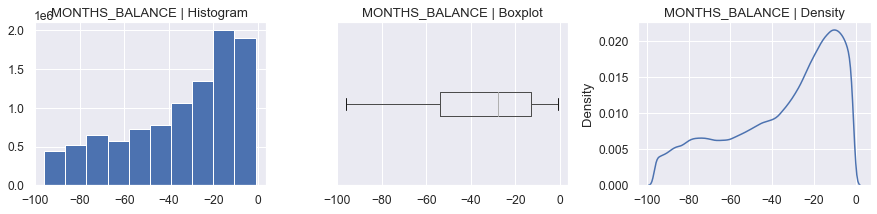

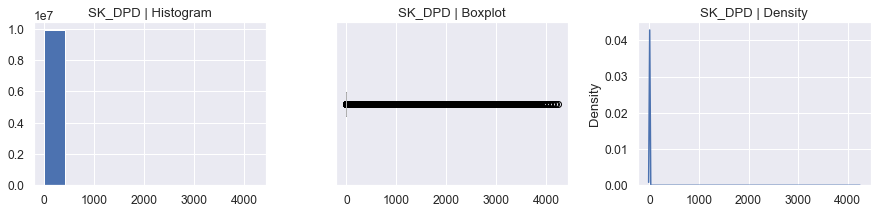

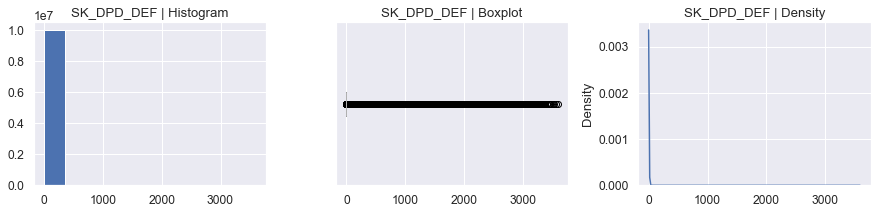

In [52]:
# Quick Visualization for numerical variables
num_plot(pos, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

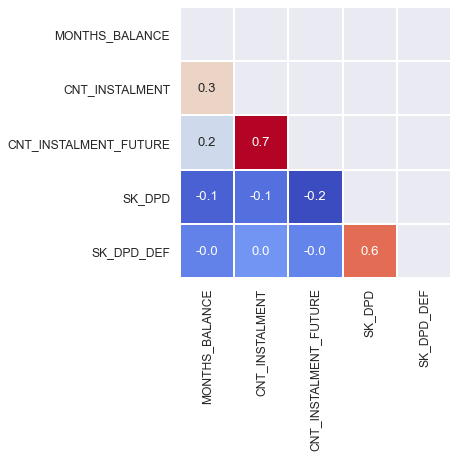

In [53]:
# Correlation
corr_plot(pos, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (5,5))

## Data Manipulation & Feature Engineering for Pos Cash Balance


In [54]:
# Rare
pos["NAME_CONTRACT_STATUS"] = np.where(~(pos["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", pos["NAME_CONTRACT_STATUS"])

# One-Hot Encoder
pos, cat_cols = one_hot_encoder(pos, nan_as_category=False)

aggregations = {
    # Numerical
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'CNT_INSTALMENT': ['max', 'mean', 'std', 'min', 'median'],
    'CNT_INSTALMENT_FUTURE': ['max', 'mean', 'sum', 'min', 'median', 'std'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
# Categorical
for cat in cat_cols:
    aggregations[cat] = ['mean']

# Aggregation
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
pos_agg.reset_index(inplace = True)
del pos

print("POS CASH BALANCE SHAPE:", pos_agg.shape, "\n")

pos_agg.head()

POS CASH BALANCE SHAPE: (337252, 23) 



,SK_ID_CURR,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Rare_MEAN,POS_COUNT
0,100001,-53,-72.56,9,4.00,4.00,0.00,4.00,4.00,4.00,1.44,13.00,0.00,1.00,1.42,7,0.78,7,0.78,0.78,0.22,0.00,9
1,100002,-1,-10.00,19,24.00,24.00,0.00,24.00,24.00,24.00,15.00,285.00,6.00,15.00,5.63,0,0.00,0,0.00,1.00,0.00,0.00,19
2,100003,-18,-43.79,28,12.00,10.11,2.81,6.00,12.00,12.00,5.79,162.00,0.00,6.00,3.84,0,0.00,0,0.00,0.93,0.07,0.00,28
3,100004,-24,-25.50,4,4.00,3.75,0.50,3.00,4.00,4.00,2.25,9.00,0.00,2.50,1.71,0,0.00,0,0.00,0.75,0.25,0.00,4
4,100005,-15,-20.00,11,12.00,11.70,0.95,9.00,12.00,12.00,7.20,72.00,0.00,7.50,3.61,0,0.00,0,0.00,0.82,0.09,0.09,11


In [55]:
# WRITE FEATHER
pos_agg.to_feather("poscashbalance_agg_feather")
del pos_agg

# 5. Credit Card Balance

- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.


In [56]:
cc = pd.read_csv('home-credit-default-risk/credit_card_balance.csv')
cc = reduce_mem_usage(cc)

print(cc.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(cc, car_th=10)

print("")

cc.head()

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%
(3840312, 23) 

Observations: 3840312
Variables: 23
date_cols: 0
cat_cols: 1
num_cols: 7
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,"1,700.32","1,800.00","1,800.00",0.00,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,2582071,363914,-1,"63,975.55",45000,"2,250.00","2,250.00",0.00,0.00,"2,250.00","2,250.00","2,250.00","60,175.08","64,875.55","64,875.55",1.00,1,0.00,0.00,69.00,Active,0,0
2,1740877,371185,-7,"31,815.22",450000,0.00,0.00,0.00,0.00,"2,250.00","2,250.00","2,250.00","26,926.43","31,460.09","31,460.09",0.00,0,0.00,0.00,30.00,Active,0,0
3,1389973,337855,-4,"236,572.11",225000,"2,250.00","2,250.00",0.00,0.00,"11,795.76","11,925.00","11,925.00","224,949.28","233,048.97","233,048.97",1.00,1,0.00,0.00,10.00,Active,0,0
4,1891521,126868,-1,"453,919.47",450000,0.00,"11,547.00",0.00,"11,547.00","22,924.89","27,000.00","27,000.00","443,044.41","453,919.47","453,919.47",0.00,1,0.00,1.00,101.00,Active,0,0


## EDA for Credit Card Balance

In [57]:
# Are there any missing values in the data?
missing_values(cc, plot = False)

Number of Variables include Missing Values: 9 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0         AMT_PAYMENT_CURRENT       767988           0.20   float32
1    AMT_DRAWINGS_ATM_CURRENT       749816           0.20   float32
2    CNT_DRAWINGS_POS_CURRENT       749816           0.20   float16
3  AMT_DRAWINGS_OTHER_CURRENT       749816           0.20   float32
4    AMT_DRAWINGS_POS_CURRENT       749816           0.20   float32
5  CNT_DRAWINGS_OTHER_CURRENT       749816           0.20   float16
6    CNT_DRAWINGS_ATM_CURRENT       749816           0.20   float16
7   CNT_INSTALMENT_MATURE_CUM       305236           0.08   float16
8     AMT_INST_MIN_REGULARITY       305236           0.08   float32 



In [58]:
# Cat Analyzer
cat_analyzer(cc, "NAME_CONTRACT_STATUS")

NAME_CONTRACT_STATUS
                 COUNT  RATIO
Active         3698436   0.96
Completed       128918   0.03
Signed           11058   0.00
Demand            1365   0.00
Sent proposal      513   0.00
Refused             17   0.00
Approved             5   0.00




In [59]:
# Numeric Features
cc.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
mean,-34.52,"58,276.86","153,807.96","5,962.30","7,432.26",288.16,"2,968.84","3,541.78","10,211.03","7,564.77","55,950.36","58,085.02","58,094.59",NaN,0.70,0.00,NaN,NaN,9.28,0.33
std,26.67,"107,464.14","165,145.70","28,033.97","33,366.82","8,197.02","20,663.21","5,525.35","35,791.42","31,594.29","101,517.74","107,176.88","107,180.20",0.00,3.19,0.08,0.00,0.00,97.52,21.48
min,-96.00,"-420,250.19",0.00,"-6,827.31","-6,211.62",0.00,0.00,0.00,0.00,0.00,"-423,305.81","-420,250.19","-420,250.19",0.00,0.00,0.00,0.00,0.00,0.00,0.00
1%,-93.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-487.26,-486.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10%,-76.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-55.00,0.00,"45,000.00",0.00,0.00,0.00,0.00,0.00,152.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00
50%,-28.00,0.00,"112,500.00",0.00,0.00,0.00,0.00,0.00,"2,702.70",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,0.00,0.00
75%,-11.00,"89,046.69","180,000.00",0.00,0.00,0.00,0.00,"6,633.91","9,000.00","6,750.00","85,359.24","88,899.49","88,914.51",0.00,0.00,0.00,0.00,32.00,0.00,0.00
80%,-9.00,"116,880.70","225,000.00",0.00,0.00,0.00,0.00,"7,283.97","10,800.00","9,000.00","111,982.27","116,663.39","116,690.04",0.00,0.00,0.00,0.00,37.00,0.00,0.00
90%,-5.00,"180,016.20","427,500.00","6,750.00","11,250.00",0.00,0.00,"9,000.00","18,900.00","13,500.00","173,228.92","179,815.77","179,830.17",1.00,1.00,0.00,0.00,51.00,0.00,0.00


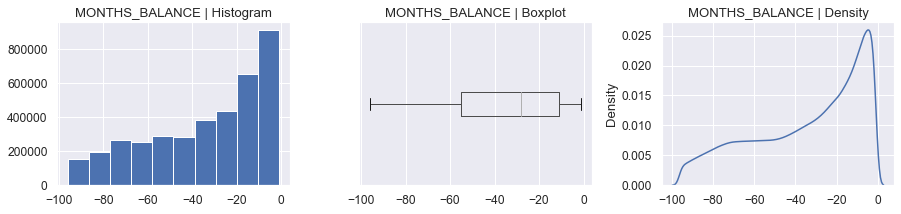

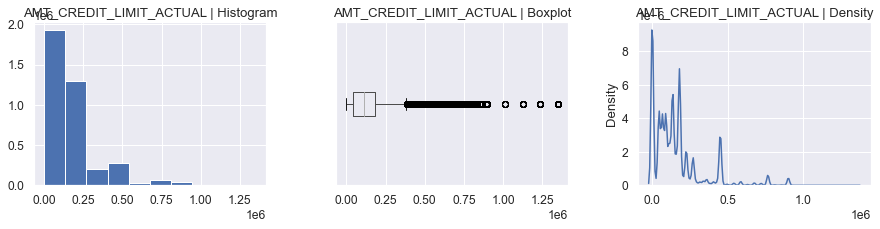

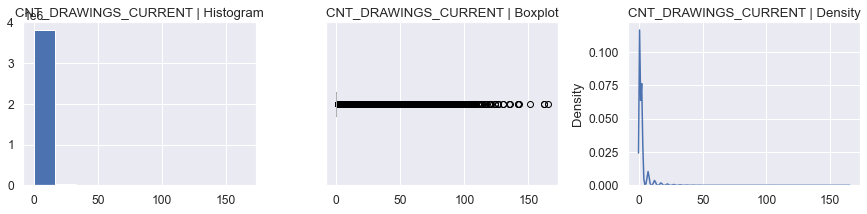

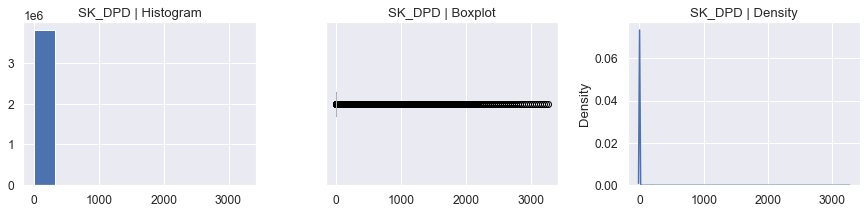

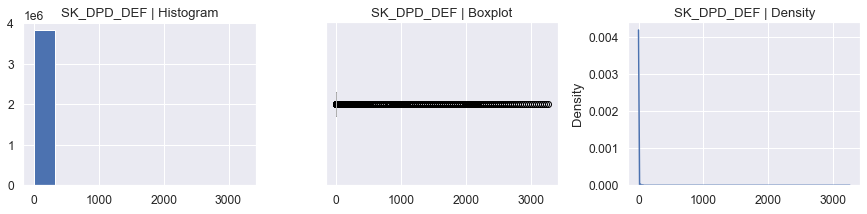

In [60]:
# Quick Visualization for numerical variables
num_plot(cc, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

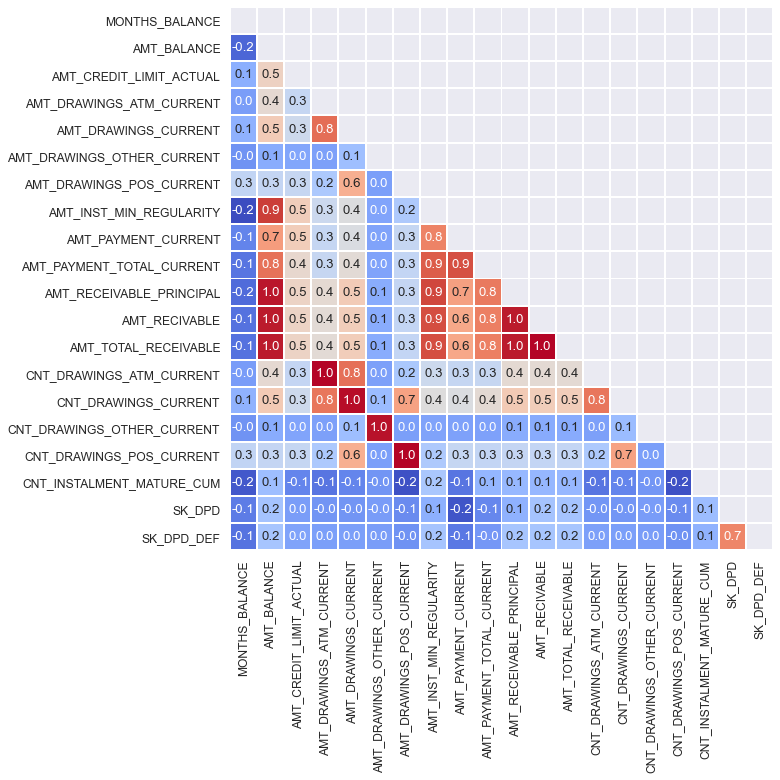

In [61]:
# Correlation
corr_plot(cc, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (10,10))

## Data Manipulation & Feature Engineering for Credit Card Balance

In [62]:
# Rare
cc["NAME_CONTRACT_STATUS"] = np.where(~(cc["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", cc["NAME_CONTRACT_STATUS"])

# One Hot Encoder
cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)

# General aggregations
cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'std'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
cc_agg.reset_index(inplace = True)
del cc

print("CREDIT CARD BALANCE SHAPE:", cc_agg.shape, "\n")

cc_agg.head()

CREDIT CARD BALANCE SHAPE: (103558, 117) 



,SK_ID_CURR,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_STD,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_STD,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_STD,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_STD,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_STD,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_STD,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_STD,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_STD,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_STD,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_STD,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_STD,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_STD,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_STD,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_STD,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_STD,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_STD,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_STD,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_STD,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_STD,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_STD,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_STD,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_STD,CC_NAME_CONTRACT_STATUS_Rare_MIN,CC_NAME_CONTRACT_STATUS_Rare_MAX,CC_NAME_CONTRACT_STATUS_Rare_MEAN,CC_NAME_CONTRACT_STATUS_Rare_SUM,CC_NAME_CONTRACT_STATUS_Rare_STD,CC_COUNT
0,100006,-6,-1,-3.50,-21.00,1.87,0.00,0.00,0.00,0.00,0.00,270000,270000,"270,000.00",1620000,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,0,0,0.00,0,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0,0,0.00,0.00,0.00,1,1,1.00,6,0.00,0,0,0.00,0,0.00,0,0,0.00,0,0.00,6
1,100011,-75,-2,-38.50,"-2,849.00",21.51,0.00,"189,000.00","54,482.11","4,031,676.25","68,127.24"

In [63]:
# WRITE FEATHER
cc_agg.to_feather("cc_feather")
del cc_agg

# 6. Installments Payments

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [64]:
ins = pd.read_csv('home-credit-default-risk/installments_payments.csv')
ins = reduce_mem_usage(ins)

print(ins.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(ins, car_th=10)

print("")

ins.head()

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
(13605401, 8) 

Observations: 13605401
Variables: 8
date_cols: 0
cat_cols: 0
num_cols: 3
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,"-1,180.00","-1,187.00","6,948.36","6,948.36"
1,1330831,151639,0.00,34,"-2,156.00","-2,156.00","1,716.53","1,716.53"
2,2085231,193053,2.00,1,-63.00,-63.00,"25,425.00","25,425.00"
3,2452527,199697,1.00,3,"-2,418.00","-2,426.00","24,350.13","24,350.13"
4,2714724,167756,1.00,2,"-1,383.00","-1,366.00","2,165.04","2,160.58"


## EDA for Installments Payments


In [65]:
# Are there any missing values in the data?
missing_values(ins, plot = False)

Number of Variables include Missing Values: 2 

              Feature  Num_Missing  Missing_Ratio DataTypes
0  DAYS_ENTRY_PAYMENT         2905           0.00   float16
1         AMT_PAYMENT         2905           0.00   float32 



In [66]:
# Numeric Features
ins.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
mean,NaN,18.87,NaN,NaN,"16,750.76","16,915.04"
std,0.00,26.66,NaN,NaN,"49,642.95","53,759.81"
min,0.00,1.00,"-2,922.00","-4,920.00",0.00,0.00
1%,0.00,1.00,"-2,832.00","-2,836.00",13.27,3.78
10%,0.00,2.00,"-2,308.00","-2,316.00",717.71,331.83
25%,0.00,4.00,"-1,654.00","-1,662.00","4,226.08","3,398.26"
50%,1.00,8.00,-818.00,-827.00,"8,884.08","8,125.52"
75%,1.00,19.00,-361.00,-370.00,"16,710.21","16,108.42"
80%,1.00,25.00,-288.00,-298.00,"20,131.83","19,350.00"
90%,1.00,56.00,-150.00,-159.00,"31,415.18","31,179.91"


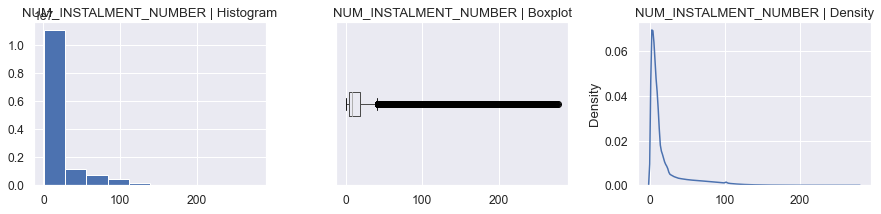

In [67]:
# Quick Visualization for numerical variables
num_plot(ins, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

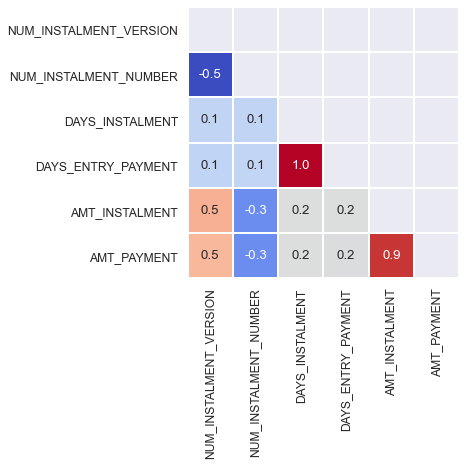

In [68]:
# Correlation
corr_plot(ins, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (5,5))

In [69]:
high_correlation(ins, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", corr_value = 0.7)

DAYS_INSTALMENT
-------------------------------
DAYS_ENTRY_PAYMENT   1.00
Name: DAYS_INSTALMENT, dtype: float64


DAYS_ENTRY_PAYMENT
-------------------------------
DAYS_INSTALMENT   1.00
Name: DAYS_ENTRY_PAYMENT, dtype: float64


AMT_INSTALMENT
-------------------------------
AMT_PAYMENT   0.92
Name: AMT_INSTALMENT, dtype: float64


AMT_PAYMENT
-------------------------------
AMT_INSTALMENT   0.92
Name: AMT_PAYMENT, dtype: float64




## Data Manipulation & Feature Engineering for Installments Payments


In [70]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'NUM_INSTALMENT_NUMBER': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'median', 'std'],
    'DPD': ['max', 'mean', 'sum', 'median', 'std'],
    'DBD': ['max', 'mean', 'sum', 'median', 'std'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'std', 'median'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'std', 'median']
}

ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()

ins_agg.reset_index(inplace = True)
del ins



print("INSTALLMENTS PAYMENTS SHAPE:", ins_agg.shape, "\n")

ins_agg.head()

INSTALLMENTS PAYMENTS SHAPE: (339587, 49) 



,SK_ID_CURR,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_NUM_INSTALMENT_NUMBER_MAX,INS_NUM_INSTALMENT_NUMBER_MEAN,INS_NUM_INSTALMENT_NUMBER_SUM,INS_NUM_INSTALMENT_NUMBER_MEDIAN,INS_NUM_INSTALMENT_NUMBER_STD,INS_DAYS_INSTALMENT_MAX,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_INSTALMENT_SUM,INS_DAYS_INSTALMENT_MEDIAN,INS_DAYS_INSTALMENT_STD,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_SUM,INS_DAYS_ENTRY_PAYMENT_MEDIAN,INS_DAYS_ENTRY_PAYMENT_STD,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,INS_AMT_INSTALMENT_MEDIAN,INS_AMT_INSTALMENT_STD,INS_AMT_PAYMENT_MIN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_SUM,INS_AMT_PAYMENT_MEDIAN,INS_AMT_PAYMENT_STD,INS_DPD_MAX,INS_DPD_MEAN,INS_DPD_SUM,INS_DPD_MEDIAN,INS_DPD_STD,INS_DBD_MAX,INS_DBD_MEAN,INS_DBD_SUM,INS_DBD_MEDIAN,INS_DBD_STD,INS_PAYMENT_PERC_MAX,INS_PAYMENT_PERC_MEAN,INS_PAYMENT_PERC_SUM,INS_PAYMENT_PERC_STD,INS_PAYMENT_PERC_MEDIAN,INS_PAYMENT_DIFF_MAX,INS_PAYMENT_DIFF_MEAN,INS_PAYMENT_DIFF_SUM,INS_PAYMENT_DIFF_STD,INS_PAYMENT_DIFF_MEDIAN,INS_COUNT
0,100001,2,4,2.71,19.00,3.00,1.11,"-1,619.00","-2,188.00","-15,312.00","-1,709.00",653.99,"-1,628.00","-2,196.00","-15,368.00","-1,715.00",644.08,"17,397.90","5,885.13","41,195.93","3,980.93","5,076.68","3,951.00","17,397.90","5,885.13","41,195.93","3,980.93","5,076.68",10.00,1.43,10.00,0.00,3.78,36.00,8.86,62.00,6.00,12.81,1.00,1.00,7.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,7
1,100002,2,19,10.00,190.00,10.00,5.63,-25.00,-295.00,"-5,604.00",-295.00,168.82,-49.00,-315.50,"-5,992.00",-312.00,172.06,"53,093.75","11,559.25","219,625.70","9,251.78","10,058.04","9,251.78","53,093.75","11,559.25","219,625.70","9,251.78","10,058.04",0.00,0.00,0.00,0.00,0.00,31.00,20.42,388.00,19.00,4.93,1.00,1.00,19.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,19
2,100003,2,12,5.08,127.00,5.00,3.13,-536.00,"-1,378.00","-34,464.00",-797.00,757.45,-544.00,"-1,385.00","-34,624.00",-806.00,757.37,"560,835.38","64,754.59","1,618,864.62","64,275.61","110,542.59","6,662.97","560,835.38","64,754.59","1,618,864.62","64,275.61","110,542.59",0.00,0.00,0.00,0.00,0.00,14.00,7.20,180.00,6.00,3.72,1.00,1.00,25.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,25
3,100004,2,3,2.00,6.00,2.00,1.00,-724.00,-754.00,"-2,262.00",-754.00,30.00,-727.00,-761.50,"-2,284.00",-763.00,34.02,"10,573.96","7,096.15","21,288.46","5,357.25","3,011.87","5,357.25","10,573.96","7,096.15","21,288.46","5,357.25","3,011.87",0.00,0.00,0.00,0.00,0.00,11.00,7.67,23.00,9.00,4.16,1.00,1.00,3.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,3
4,100005,2,9,5.00,45.00,5.00,2.74,-466.00,-586.00,"-5,272.00",-586.00,82.16,-470.00,-609.50,"-5,488.00",-585.00,90.55,"17,656.24","6,240.21","56,161.84","4,813.20","4,281.01","4,813.20","17,656.24","6,240.21","56,161.84","4,813.20","4,281.01",1.00,0.11,1.00,0.00,0.33,37.00,23.67,213.00,29.00,13.29,1.00,1.00,9.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,9


In [71]:
# WRITE FEATHER
ins_agg.to_feather("installments_payments_agg_feather")
del ins_agg

# 7. Previous Applications

- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

In [72]:
prev = pd.read_csv('home-credit-default-risk/previous_application.csv')
prev = reduce_mem_usage(prev)

print(prev.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(prev, car_th=10)

print("")

prev.head()

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%
(1670214, 37) 

Observations: 1670214
Variables: 37
date_cols: 0
cat_cols: 13
num_cols: 5
cat_but_car: 4
num_but_cat: 1



,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,"1,730.43","17,145.00","17,145.00",0.00,"17,145.00",SATURDAY,15,Y,1,0.00,0.18,0.87,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.00,middle,POS mobile with interest,"365,243.00",-42.00,300.00,-42.00,-37.00,0.00
1,2802425,108129,Cash loans,"25,188.62","607,500.00","679,671.00",NaN,"607,500.00",THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.00,low_action,Cash X-Sell: low,"365,243.00",-134.00,916.00,"365,243.00","365,243.00",1.00
2,2523466,122040,Cash loans,"15,060.74","112,500.00","136,444.50",NaN,"112,500.00",TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,high,Cash X-Sell: high,"365,243.00",-271.00,59.00,"365,243.00","365,243.00",1.00
3,2819243,176158,Cash loans,"47,041.34","450,000.00","470,790.00",NaN,"450,000.00",MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,middle,Cash X-Sell: middle,"365,243.00",-482.00,-152.00,-182.00,-177.00,1.00
4,1784265,202054,Cash loans,"31,924.39","337,500.00","404,055.00",NaN,"337,500.00",THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.00,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## EDA for Previous Applications


In [73]:
# Are there any missing values in the data?
missing_values(prev, plot = False)

Number of Variables include Missing Values: 16 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0    RATE_INTEREST_PRIVILEGED      1664263           1.00   float16
1       RATE_INTEREST_PRIMARY      1664263           1.00   float16
2            AMT_DOWN_PAYMENT       895844           0.54   float32
3           RATE_DOWN_PAYMENT       895844           0.54   float16
4             NAME_TYPE_SUITE       820405           0.49  category
5   NFLAG_INSURED_ON_APPROVAL       673065           0.40   float16
6            DAYS_TERMINATION       673065           0.40   float32
7               DAYS_LAST_DUE       673065           0.40   float32
8   DAYS_LAST_DUE_1ST_VERSION       673065           0.40   float32
9              DAYS_FIRST_DUE       673065           0.40   float32
10         DAYS_FIRST_DRAWING       673065           0.40   float32
11            AMT_GOODS_PRICE       385515           0.23   float32
12                AMT_ANNUITY       372235           0.22   float32

In [74]:
# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(prev, car_th=10)

print("")

# Categorical Features
print(cat_cols, cat_but_car)

Observations: 1670214
Variables: 37
date_cols: 0
cat_cols: 13
num_cols: 5
cat_but_car: 4
num_but_cat: 1

['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP', 'NFLAG_LAST_APPL_IN_DAY'] ['NAME_CASH_LOAN_PURPOSE', 'NAME_GOODS_CATEGORY', 'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION']


In [75]:
# Cat Analyzer
for i in cat_cols + cat_but_car:
    cat_analyzer(prev, i)

NAME_CONTRACT_TYPE
                  COUNT  RATIO
Cash loans       747553   0.45
Consumer loans   729151   0.44
Revolving loans  193164   0.12
XNA                 346   0.00


WEEKDAY_APPR_PROCESS_START
            COUNT  RATIO
TUESDAY    255118   0.15
WEDNESDAY  255010   0.15
MONDAY     253557   0.15
FRIDAY     252048   0.15
THURSDAY   249099   0.15
SATURDAY   240631   0.14
SUNDAY     164751   0.10


FLAG_LAST_APPL_PER_CONTRACT
     COUNT  RATIO
Y  1661739   0.99
N     8475   0.01


NAME_CONTRACT_STATUS
                COUNT  RATIO
Approved      1036781   0.62
Canceled       316319   0.19
Refused        290678   0.17
Unused offer    26436   0.02


NAME_PAYMENT_TYPE
                                             COUNT  RATIO
Cash through the bank                      1033552   0.62
XNA                                         627384   0.38
Non-cash from your account                    8193   0.00
Cashless from the account of the employer     1085   0.00


CODE_REJECT_REASON
          COUN

In [76]:
# Numeric Features
prev.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]


,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
mean,"15,948.89","174,980.64","196,013.12","6,699.08","227,518.19",12.48,1.00,0.08,0.19,0.77,-880.68,313.95,NaN,"340,114.34","13,838.13","33,764.87","76,829.15","82,314.84",NaN
std,"14,776.95","293,300.53","317,783.66","20,905.72","315,460.50",3.33,0.06,0.11,0.09,0.10,779.10,"7,127.44",0.00,"88,611.61","72,421.30","106,544.81","150,155.11","152,926.94",0.00
min,0.00,0.00,0.00,-0.90,0.00,0.00,0.00,-0.00,0.03,0.37,"-2,922.00",-1.00,0.00,"-2,922.00","-2,892.00","-2,801.00","-2,889.00","-2,874.00",0.00
1%,"2,137.18",0.00,0.00,0.00,"15,300.00",5.00,1.00,0.00,0.06,0.42,"-2,835.00",-1.00,0.00,"-2,441.00","-2,822.00","-2,599.00","-2,618.00","-2,589.00",0.00
10%,"3,817.53",0.00,0.00,0.00,"30,555.00",8.00,1.00,0.00,0.14,0.64,"-2,250.00",-1.00,0.00,"365,243.00","-2,392.00","-2,047.00","-2,081.00","-2,052.00",0.00
25%,"6,321.78","18,720.00","24,160.50",0.00,"50,841.00",10.00,1.00,0.00,0.16,0.72,"-1,300.00",-1.00,6.00,"365,243.00","-1,628.00","-1,242.00","-1,314.00","-1,270.00",0.00
50%,"11,250.00","71,046.00","80,541.00","1,638.00","112,320.00",12.00,1.00,0.05,0.19,0.83,-581.00,3.00,12.00,"365,243.00",-831.00,-361.00,-537.00,-499.00,0.00
75%,"20,658.42","180,360.00","216,418.50","7,740.00","234,000.00",15.00,1.00,0.11,0.19,0.85,-280.00,82.00,24.00,"365,243.00",-411.00,129.00,-74.00,-44.00,1.00
80%,"23,638.50","228,937.50","270,000.00","9,450.00","315,000.00",16.00,1.00,0.11,0.19,0.85,-239.00,140.00,24.00,"365,243.00",-332.00,267.00,"365,243.00","365,243.00",1.00
90%,"34,703.82","450,000.00","533,160.00","17,109.00","585,000.00",17.00,1.00,0.21,0.20,0.87,-152.00,919.00,36.00,"365,243.00",-173.00,"1,432.00","365,243.00","365,243.00",1.00


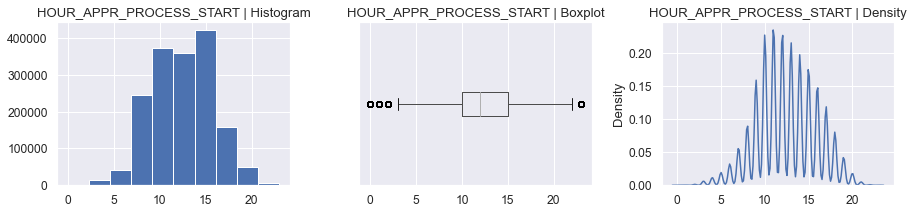

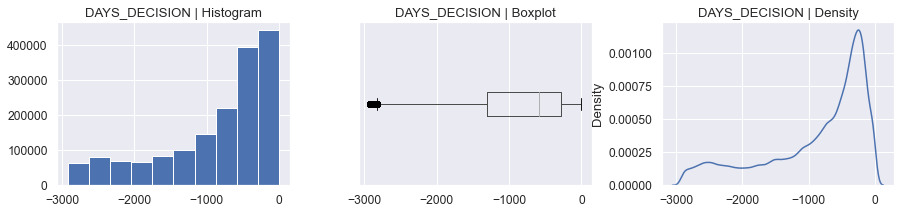

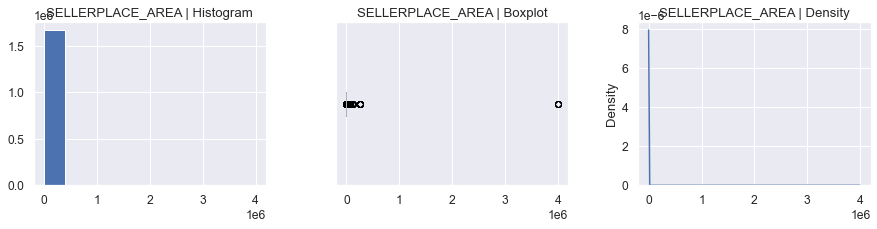

In [77]:
# Quick Visualization for numerical variables
num_plot(prev, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

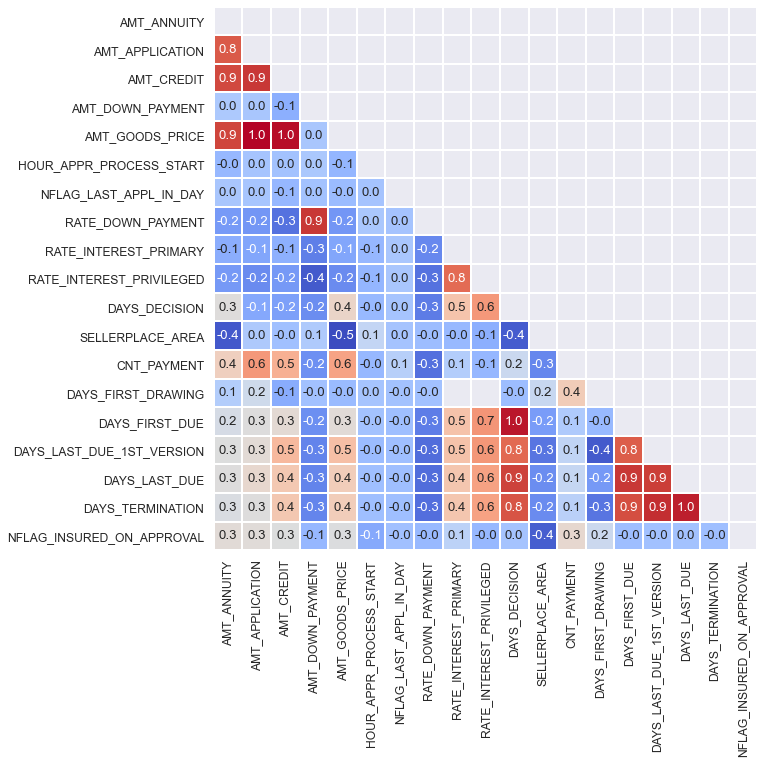

In [78]:
# Correlation
corr_plot(prev, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (10,10))

In [79]:
high_correlation(prev, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", corr_value = 0.7)

AMT_ANNUITY
-------------------------------
AMT_GOODS_PRICE   0.89
AMT_CREDIT        0.88
AMT_APPLICATION   0.83
Name: AMT_ANNUITY, dtype: float64


AMT_APPLICATION
-------------------------------
AMT_GOODS_PRICE   1.00
AMT_CREDIT        0.92
AMT_ANNUITY       0.83
Name: AMT_APPLICATION, dtype: float64


AMT_CREDIT
-------------------------------
AMT_GOODS_PRICE   0.98
AMT_APPLICATION   0.92
AMT_ANNUITY       0.88
Name: AMT_CREDIT, dtype: float64


AMT_DOWN_PAYMENT
-------------------------------
RATE_DOWN_PAYMENT   0.92
Name: AMT_DOWN_PAYMENT, dtype: float64


AMT_GOODS_PRICE
-------------------------------
AMT_APPLICATION   1.00
AMT_CREDIT        0.98
AMT_ANNUITY       0.89
Name: AMT_GOODS_PRICE, dtype: float64


RATE_DOWN_PAYMENT
-------------------------------
AMT_DOWN_PAYMENT   0.92
Name: RATE_DOWN_PAYMENT, dtype: float64


RATE_INTEREST_PRIMARY
-------------------------------
RATE_INTEREST_PRIVILEGED   0.78
Name: RATE_INTEREST_PRIMARY, dtype: float64


RATE_INTEREST_PRIVILEGED
--

## Data Manipulation & Feature Engineering for Previous Applications

In [80]:
# Rare Encoder
rare_cols = [
    "NAME_PAYMENT_TYPE", "CODE_REJECT_REASON", "CHANNEL_TYPE", "NAME_GOODS_CATEGORY",
    "NAME_SELLER_INDUSTRY", "NAME_TYPE_SUITE"
]

for i in rare_cols:
    rare_encoder(prev, i, rare_perc = 0.01)

prev["NAME_CASH_LOAN_PURPOSE"] = np.where(~prev["NAME_CASH_LOAN_PURPOSE"].isin(["XAP", "XNA"]), "Other",
                                          prev["NAME_CASH_LOAN_PURPOSE"])

rare_encoder(prev, "NAME_PORTFOLIO", rare_perc = 0.1) 

# Cash, Pos, Card
prev["PRODUCT_COMBINATION_CATS"] = np.where(prev["PRODUCT_COMBINATION"].str.contains("Cash"), "CASH", "POS")
prev["PRODUCT_COMBINATION_CATS"] = np.where(prev["PRODUCT_COMBINATION"].str.contains("Card"), "CARD",
                                            prev["PRODUCT_COMBINATION_CATS"])
# New categorical variables
prev["PRODUCT_COMBINATION_POS_WITH"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("without"))),
                                                "WITHOUT", "OTHER")
prev["PRODUCT_COMBINATION_POS_WITH"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("with interest"))),
                                                "WITH", prev["PRODUCT_COMBINATION_POS_WITH"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("household"))),
                                                "household", "OTHER")
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("industry"))),
                                                "industry", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("mobile"))),
                                                "mobile", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("other"))),
                                                "posother", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_CASH_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("Cash") &
                                                  (prev["PRODUCT_COMBINATION"].str.contains("X-Sell"))),
                                                 "xsell", "OTHER")
prev["PRODUCT_COMBINATION_CASH_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("Cash") &
                                                  (prev["PRODUCT_COMBINATION"].str.contains("Street"))),
                                                 "street", prev["PRODUCT_COMBINATION_CASH_TYPE"])


# Useless
prev.drop(["WEEKDAY_APPR_PROCESS_START", "FLAG_LAST_APPL_PER_CONTRACT",
           "NFLAG_LAST_APPL_IN_DAY", "NFLAG_LAST_APPL_IN_DAY"],
          axis = 1, inplace = True)

# One-Hot Encoder
prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)


# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']


# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean', "median", "std"],
    'AMT_APPLICATION': ['min', 'max', 'mean', "median", "std"],
    'AMT_CREDIT': ['min', 'max', 'mean', "median", "std"],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', "median", "std"],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', "median", "std"],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean', "median", "std"],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', "median", "std"],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean', "std"],
    'DAYS_DECISION': ['min', 'max', 'mean', "median", "std"],
    'CNT_PAYMENT': ['mean', 'sum', "median", "std"],
    'SELLERPLACE_AREA': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DRAWING': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_TERMINATION': ['min', 'max', 'mean', "median", "std"],
    # Categorical
    "NFLAG_INSURED_ON_APPROVAL": ["mean"]
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = pd.merge(prev_agg,approved_agg, how='left', on='SK_ID_CURR')

# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = pd.merge(prev_agg, refused_agg, how='left', on='SK_ID_CURR')

del refused, refused_agg, approved, approved_agg, prev
prev_agg.reset_index(inplace = True)


print("PREVIOUS APPLICATIONS SHAPE:", prev_agg.shape, "\n")

prev_agg.head()

PREVIOUS APPLICATIONS SHAPE: (338857, 378) 



,SK_ID_CURR,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MEDIAN,PREV_AMT_ANNUITY_STD,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MEDIAN,PREV_AMT_APPLICATION_STD,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MEDIAN,PREV_AMT_CREDIT_STD,PREV_APP_CREDIT_PERC_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MEDIAN,PREV_APP_CREDIT_PERC_STD,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MEDIAN,PREV_AMT_DOWN_PAYMENT_STD,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MEDIAN,PREV_AMT_GOODS_PRICE_STD,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_HOUR_APPR_PROCESS_START_MEDIAN,PREV_HOUR_APPR_PROCESS_START_STD,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_RATE_DOWN_PAYMENT_STD,PREV_RATE_INTEREST_PRIMARY_MIN,PREV_RATE_INTEREST_PRIMARY_MAX,PREV_RATE_INTEREST_PRIMARY_MEAN,PREV_RATE_INTEREST_PRIMARY_STD,PREV_RATE_INTEREST_PRIVILEGED_MIN,PREV_RATE_INTEREST_PRIVILEGED_MAX,PREV_RATE_INTEREST_PRIVILEGED_MEAN,PREV_RATE_INTEREST_PRIVILEGED_STD,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MEDIAN,PREV_DAYS_DECISION_STD,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CNT_PAYMENT_MEDIAN,PREV_CNT_PAYMENT_STD,PREV_SELLERPLACE_AREA_MIN,PREV_SELLERPLACE_AREA_MAX,PREV_SELLERPLACE_AREA_MEAN,PREV_SELLERPLACE_AREA_MEDIAN,PREV_SELLERPLACE_AREA_STD,PREV_DAYS_FIRST_DRAWING_MIN,PREV_DAYS_FIRST_DRAWING_MAX,PREV_DAYS_FIRST_DRAWING_MEAN,PREV_DAYS_FIRST_DRAWING_MEDIAN,PREV_DAYS_FIRST_DRAWING_STD,PREV_DAYS_FIRST_DUE_MIN,PREV_DAYS_FIRST_DUE_MAX,PREV_DAYS_FIRST_DUE_MEAN,PREV_DAYS_FIRST_DUE_MEDIAN,PREV_DAYS_FIRST_DUE_STD,PREV_DAYS_LAST_DUE_1ST_VERSION_MIN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MEDIAN,PREV_DAYS_LAST_DUE_1ST_VERSION_STD,PREV_DAYS_LAST_DUE_MIN,PREV_DAYS_LAST_DUE_MAX,PREV_DAYS_LAST_DUE_MEAN,PREV_DAYS_LAST_DUE_MEDIAN,PREV_DAYS_LAST_DUE_STD,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_DAYS_TERMINATION_MEAN,PREV_DAYS_TERMINATION_MEDIAN,PREV_DAYS_TERMINATION_STD,PREV_NFLAG_INSURED_ON_APPROVAL_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_NAME_CONTRACT_TYPE_nan_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,PREV_NAME_CONTRACT_STATUS_nan_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_Rare_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,PREV_NAME_PAYMENT_TYPE_nan_MEAN,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_Rare_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Rare_MEAN,"PREV_NAME_TYPE_SUITE_Spouse, partner_MEAN",PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_Repeater_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_CLIENT_TYPE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN,PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_C

In [81]:
# WRITE FEATHER
prev_agg.to_feather("previous_applications_agg_feather")
del prev_agg

# 8. Application Train/Test

- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

In [13]:
df = pd.read_csv('home-credit-default-risk/application_train.csv')
test_df = pd.read_csv('home-credit-default-risk/application_test.csv')

print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))

df = df.append(test_df)
df = reduce_mem_usage(df)

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df, car_th=10)

print("")

df.head()

Train samples: 307511, test samples: 48744
Memory usage of dataframe is 334.32 MB
Memory usage after optimization is: 72.03 MB
Decreased by 78.5%
Observations: 356255
Variables: 122
date_cols: 0
cat_cols: 48
num_cols: 6
cat_but_car: 2
num_but_cat: 34



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.00,Cash loans,M,N,Y,0,"202,500.00","406,597.50","24,700.50","351,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,"-3,648.00",-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,"-1,134.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0.00,Cash loans,F,N,N,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,"-1,186.00",-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.98,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.98,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.98,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0.00,Revolving loans,M,Y,Y,0,"67,500.00","135,000.00","6,750.00","135,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,"-4,260.00",-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-8

## Data Manipulation & Feature Engineering for Application Train/Test

In [83]:
# Are there any missing values in the data?
missing_values(df, plot = False)

Number of Variables include Missing Values: 68 

                         Feature  Num_Missing  Missing_Ratio DataTypes
0                 COMMONAREA_AVG       248360           0.70   float16
1                COMMONAREA_MODE       248360           0.70   float16
2                COMMONAREA_MEDI       248360           0.70   float16
3        NONLIVINGAPARTMENTS_AVG       246861           0.69   float16
4       NONLIVINGAPARTMENTS_MODE       246861           0.69   float16
5       NONLIVINGAPARTMENTS_MEDI       246861           0.69   float16
6             FONDKAPREMONT_MODE       243092           0.68  category
7          LIVINGAPARTMENTS_MEDI       242979           0.68   float16
8           LIVINGAPARTMENTS_AVG       242979           0.68   float16
9          LIVINGAPARTMENTS_MODE       242979           0.68   float16
10                 FLOORSMIN_AVG       241108           0.68   float16
11                FLOORSMIN_MODE       241108           0.68   float16
12                FLOORSMIN_

In [84]:
for i in cat_cols + cat_but_car + num_but_cat:
    cat_analyzer(df, i, target = "TARGET")

NAME_CONTRACT_TYPE
                  COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  \
Cash loans       326537   0.92        278232         0.08           0.00   
Revolving loans   29718   0.08         29279         0.05           0.00   

                 TARGET_STD  
Cash loans             0.28  
Revolving loans        0.23  


CODE_GENDER
      COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
F    235126   0.66        202448         0.07           0.00        0.26
M    121125   0.34        105059         0.10           0.00        0.30
XNA       4   0.00             4         0.00           0.00        0.00


FLAG_OWN_CAR
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
N  235235   0.66        202924         0.09           0.00        0.28
Y  121020   0.34        104587         0.07           0.00        0.26


FLAG_OWN_REALTY
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
N  109285   0.31         94199         

    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0       2   0.00             1         0.00           0.00         NaN
1  356253   1.00        307510         0.08           0.00        0.27


FLAG_EMP_PHONE
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0   64661   0.18         55386         0.05           0.00        0.23
1  291594   0.82        252125         0.09           0.00        0.28


FLAG_WORK_PHONE
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  284969   0.80        246203         0.08           0.00        0.27
1   71286   0.20         61308         0.10           0.00        0.30


FLAG_CONT_MOBILE
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0     652   0.00           574         0.08           0.00        0.27
1  355603   1.00        306937         0.08           0.00        0.27


FLAG_PHONE
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  256998 

                        COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  \
Advertising               500   0.00           429         0.08   
Agriculture              2746   0.01          2454         0.10   
Bank                     2881   0.01          2507         0.05   
Business Entity Type 1   6871   0.02          5984         0.08   
Business Entity Type 2  12032   0.03         10553         0.09   
Business Entity Type 3  78832   0.22         67992         0.09   
Cleaning                  303   0.00           260         0.11   
Construction             7760   0.02          6721         0.12   
Culture                   440   0.00           379         0.06   
Electricity              1106   0.00           950         0.07   
Emergency                 651   0.00           560         0.07   
Government              11912   0.03         10404         0.07   
Hotel                    1100   0.00           966         0.06   
Housing                  3393   0.01          2958         0.0

    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
1   37961   0.11         32197         0.05           0.00        0.21
2  262340   0.74        226984         0.08           0.00        0.27
3   55954   0.16         48330         0.11           0.00        0.31


REGION_RATING_CLIENT_W_CITY
     COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
-1       1   0.00             0          NaN            NaN         NaN
 1   40342   0.11         34167         0.05           0.00        0.21
 2  265260   0.74        229484         0.08           0.00        0.27
 3   50652   0.14         43860         0.11           0.00        0.32


REG_REGION_NOT_LIVE_REGION
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  350680   0.98        302854         0.08           0.00        0.27
1    5575   0.02          4657         0.09           0.00        0.29


REG_REGION_NOT_WORK_REGION
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MED

In [85]:
# Numeric Features
df.drop(["SK_ID_CURR" ], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
mean,0.08,0.41,"170,007.72","587,568.62","27,428.09","527,535.12",0.02,"-16,041.25","64,317.23",NaN,"-3,002.07",NaN,1.00,0.82,0.20,1.00,0.28,0.07,NaN,2.05,2.03,12.06,0.02,0.05,0.04,0.08,0.23,0.18,NaN,NaN,NaN,0.12,0.09,NaN,NaN,0.05,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,NaN,NaN,0.04,0.08,0.15,0.22,0.23,0.07,0.11,0.11,0.01,0.03,0.12,0.09,NaN,NaN,0.05,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.10,NaN,0.14,NaN,0.10,NaN,0.00,0.72,0.00,0.02,0.09,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.03,NaN,NaN,NaN
std,0.27,0.72,"223,490.95","398,634.47","14,731.54","365,942.41",0.01,"4,358.80","141,705.53",NaN,"1,517.90",0.00,0.00,0.39,0.40,0.04,0.45,0.26,0.00,0.51,0.50,3.27,0.12,0.22,0.20,0.27,0.42,0.38,0.00,0.00,0.00,0.11,0.08,0.00,0.00,0.08,0.14,0.10,0.15,0.16,0.08,0.09,0.11,0.05,0.07,0.11,0.08,0.00,0.00,0.08,0.13,0.10,0.14,0.16,0.08,0.10,0.11,0.05,0.07,0.11,0.08,0.00,0.00,0.08,0.14,0.10,0.15,0.16,0.08,0.09,0.11,0.05,0.07,0.11,NaN,0.00,NaN,0.37,NaN,0.01,0.45,0.01,0.12,0.28,0.01,0.27,0.06,0.00,0.06,0.00,0.06,0.05,0.03,0.09,0.02,0.08,0.02,0.02,0.02,0.08,0.10,0.19,0.00,NaN,0.00
min,0.00,0.00,"25,650.00","45,000.00","1,615.50","40,500.00",0.00,"-25,229.00","-17,912.00","-24,672.00","-7,197.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"-4,360.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1%,0.00,0.00,"45,000.00","76,410.00","6,142.50","67,500.00",0.00,"-24,404.00","-10,856.00","-13,896.00","-5,476.00",0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.03,0.07,0.00,0.00,0.95,0.35,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.37,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

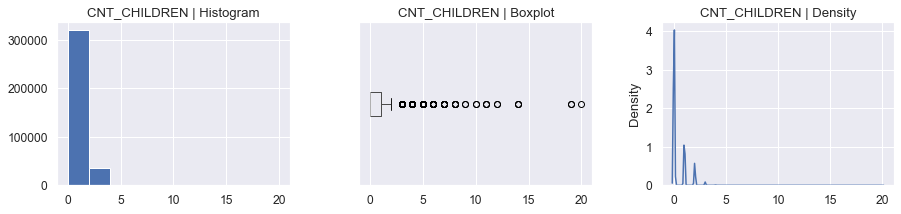

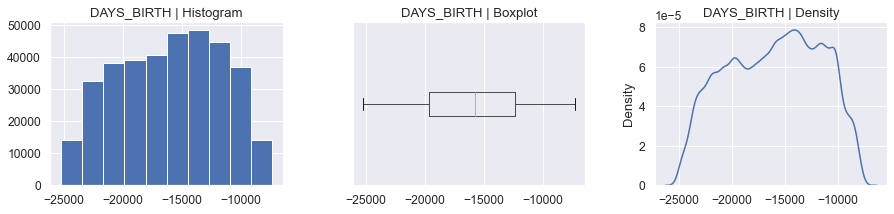

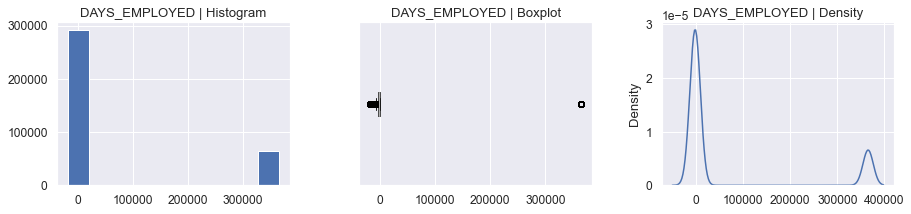

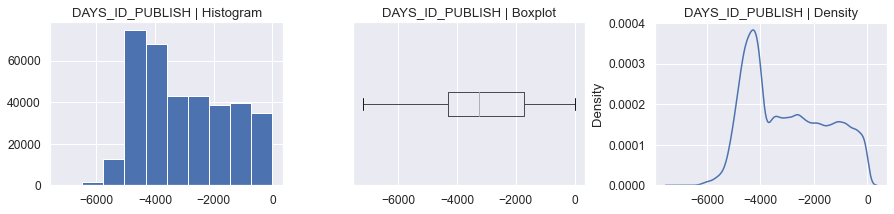

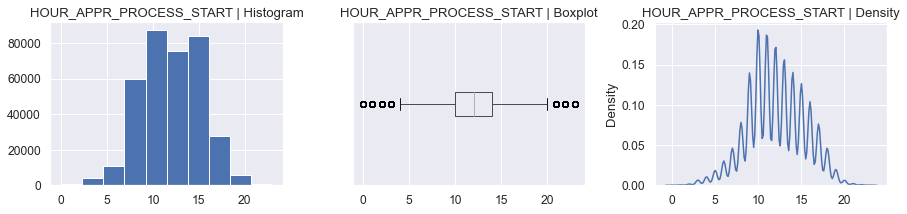

In [86]:
# Quick Visualization for numerical variables
num_plot(df, num_cols=num_cols, remove=['SK_ID_CURR'], figsize = (15,3))

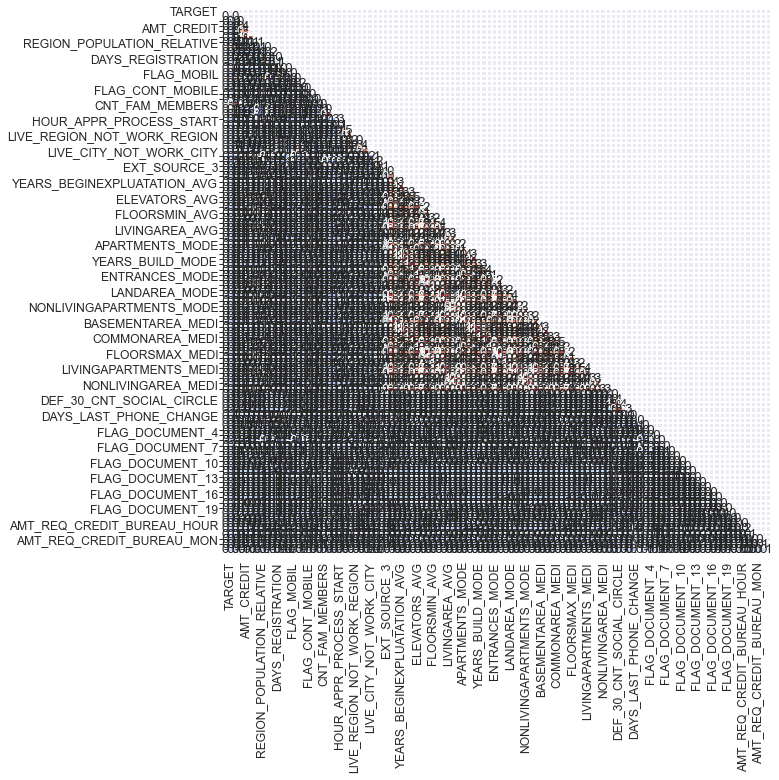

In [87]:
# Correlation
corr_plot(df, remove=['SK_ID_CURR'], corr_coef = "spearman", figsize = (10,10))

In [88]:
high_correlation(df, remove=['SK_ID_CURR'], corr_coef = "spearman", corr_value = 0.7)

CNT_CHILDREN
-------------------------------
CNT_FAM_MEMBERS   0.81
Name: CNT_CHILDREN, dtype: float64


AMT_CREDIT
-------------------------------
AMT_GOODS_PRICE   0.98
AMT_ANNUITY       0.82
Name: AMT_CREDIT, dtype: float64


AMT_ANNUITY
-------------------------------
AMT_CREDIT        0.82
AMT_GOODS_PRICE   0.82
Name: AMT_ANNUITY, dtype: float64


AMT_GOODS_PRICE
-------------------------------
AMT_CREDIT    0.98
AMT_ANNUITY   0.82
Name: AMT_GOODS_PRICE, dtype: float64


CNT_FAM_MEMBERS
-------------------------------
CNT_CHILDREN   0.81
Name: CNT_FAM_MEMBERS, dtype: float64


REGION_RATING_CLIENT
-------------------------------
REGION_RATING_CLIENT_W_CITY   0.95
Name: REGION_RATING_CLIENT, dtype: float64


REGION_RATING_CLIENT_W_CITY
-------------------------------
REGION_RATING_CLIENT   0.95
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64


REG_REGION_NOT_WORK_REGION
-------------------------------
LIVE_REGION_NOT_WORK_REGION   0.86
Name: REG_REGION_NOT_WORK_REGION, dtype: flo

## Data Manipulation & Feature Engineering for Application Train/Test

In [89]:
# ERRORS
df = df[~(df.CODE_GENDER.str.contains("XNA"))]  
df = df[df.NAME_FAMILY_STATUS != "Unknown"]  

# DROP
cols = ["NAME_HOUSING_TYPE", "WEEKDAY_APPR_PROCESS_START", "FONDKAPREMONT_MODE",
        "WALLSMATERIAL_MODE", "HOUSETYPE_MODE","EMERGENCYSTATE_MODE","FLAG_MOBIL",
        "FLAG_EMP_PHONE","FLAG_WORK_PHONE", "FLAG_CONT_MOBILE",
        "FLAG_PHONE", "FLAG_EMAIL"]
df.drop(cols, axis = 1, inplace = True)

# REGION
cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION",
        "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY",
        "REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"]
df["REGION"] = df[cols].sum(axis = 1)
df.drop(cols, axis = 1, inplace = True)

# Drop FLAG_DOCUMENT 
df.drop(df.columns[df.columns.str.contains("FLAG_DOCUMENT")], axis = 1, inplace = True)


# RARE ENCODER
df["NAME_EDUCATION_TYPE"] = np.where(df.NAME_EDUCATION_TYPE == "Academic degree",
                                     "Higher education", df.NAME_EDUCATION_TYPE)


df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Business Entity"),
                                   "Business Entity", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Industry"),
                                   "Industry", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Trade"),
                                   "Trade", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Transport"),
                                   "Transport", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["School", "Kindergarten", "University"]),
                                   "Education", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Emergency","Police", "Medicine",
                                                              "Goverment", "Postal", "Military",
                                                              "Security Ministries", "Legal Services"]),
                                   "Public", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Bank", "Insurance"]),
                                   "Finance", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Realtor", "Housing"]),
                                   "House", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Hotel", "Restaurant"]),
                                   "HotelRestaurant", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Cleaning","Electricity",
                                                              "Telecom","Mobile", "Advertising",
                                                              "Religion", "Culture"]),
                                   "Other", df.ORGANIZATION_TYPE)

df["OCCUPATION_TYPE"] = np.where(df.OCCUPATION_TYPE.isin(["Low-skill Laborers", "Cooking staff",
                                                          "Security staff", "Private service staff",
                                                          "Cleaning staff", "Waiters/barmen staff"]),
                                 "Low-skill Laborers", df.OCCUPATION_TYPE)
df["OCCUPATION_TYPE"] = np.where(df.OCCUPATION_TYPE.isin(["IT staff", "High skill tech staff"]),
                                 "High skill tech staff", df.OCCUPATION_TYPE)


rare_cols = ["NAME_TYPE_SUITE", "NAME_INCOME_TYPE"]

for i in rare_cols:
    rare_encoder(df, i, rare_perc = 0.01)

    
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ["NAME_CONTRACT_TYPE", 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    
# Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df, nan_as_category=False)


# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']


# EXT SOURCE MEAN FROM OTHER ASSOCIATIONS 
df["NEW_EXT_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_APP_EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# Satın alınacak ürünün toplam kredi tutarına oranı
df["NEW_GOODS_CREDIT"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]


# Ürün ile kredi ile  arasındaki farkın toplam yıllık gelire oranı
df["NEW_C_GP"] = (df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]) / df["AMT_INCOME_TOTAL"]


# Başvuru sırasında müşterinin gün cinsinden yaşı eksili olarak verilmiş
# -1 ile çarpıp 365'e böldüğümüzde kaç yaşında olduğunu buluyoruz

df["NEW_APP_AGE"] = round(df["DAYS_BIRTH"] * -1 / 365)

df['NEW_LOAN_VALUE_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']


df['INCOME_PER_PERSON_PERC_PAYMENT_RATE'] = df['INCOME_PER_PERSON'] / df['PAYMENT_RATE']

print("APPLICATION TRAIN/TEST SHAPE:", df.shape, "\n")
df.head()

APPLICATION TRAIN/TEST SHAPE: (356249, 140) 



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_APP_EXT_SOURCES_PROD,NEW_GOODS_CREDIT,NEW_C_GP,NEW_APP_AGE,NEW_LOAN_VALUE_RATIO,INCOME_PER_PERSON_PERC_PAYMENT_RATE
0,100002,1.00,0,0,0,0,0,"202,500.00","406,597.50","24,700.50","351,000.00",0.02,-9461,-637.00,"-3,648.00",-2120,NaN,1.00,2,2,10,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.01,2.00,2.00,2.00,2.00,"-1,134.00",0.00,0.00,0.00,0.00,0.00,1.00,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.07,0.50,"202,500.00",0.12,0.06,0.16,0.00,0.86,-0.27,26.00,1.16,"3,333,373.50"
1,100003,0.00,0,1,0,1,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",0.00,-16765,"-1,188.00","-1,186.00",-291,NaN,2.00,1,1,11,0.31,0.62,NaN,0.10,0.05,0.98,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.98,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.98,0.80,0.06,0.08,0.0

In [90]:
# WRITE FEATHER
df.reset_index(drop = True).to_feather("applications_traintest_feather")
del df